In [2]:
%matplotlib inline
from setup import *
from analysis.util_plot import *

<h1>Generate feature matrix csv </h1>

In [4]:
width = -1
for fconn in ['broadband_CC','alphatheta','beta','lowgamma','highgamma']:
    skip_chop = True
    skip_mayo = False
    skip_hup = False

    dilate_radius = 0
    all_cres = gather_cres_results(dilate_radius,fconn)
    all_cres = get_norm(all_cres,width=width)
    width = len(map(lambda x: x.values(), all_cres.values())[0][0])
    pt_iter = 0

    patient_idx = all_cres.keys()
    
    out_txt = 'pt_id,' #First column
    index_col = []    
    ft_matrix = []

    for patient_id in sorted(patient_idx):
            if(skip_chop and 'CHOP' in patient_id):
                continue
            if(skip_mayo and 'Study' in patient_id):
                continue
            if(skip_hup and 'HUP' in patient_id):
                continue
            if not all_cres[patient_id]:
                continue
            index_col.append(patient_id)
            row_data = np.array((pt_iter+1,))    
            for pid,clips in sorted(all_cres.items(), key=lambda x:x[0]):
                if(pid != patient_id):
                    continue
                if fconn == 'broadband_CC': # print only once
                    print patient_id
                outcome = data['PATIENTS'][patient_id]['Outcome']
                avg_data = np.array(())
                for clip_id, clip in sorted(clips.items(), key=lambda x:x[0]):
                    try:                
                        avg_data = np.hstack((avg_data,np.reshape(clip,(clip.shape[0],1))))
                    except Exception:                
                        avg_data = np.reshape(clip,(clip.shape[0],1))

                avg_data = np.nanmedian(avg_data,axis=1)

                # Update row_data
                row_data = np.hstack((row_data,avg_data)) 

                # Update header
                if(pt_iter == 0):
                    for t in range(1,clip.shape[0]+1):
                        out_txt += 'cres_'+str(t)+'_%s,'%fconn
            if(get_outcome(outcome) == 'Good'):        
                row_data = np.hstack((row_data,[0]))        
            else:
                row_data = np.hstack((row_data,[1]))
            ft_matrix.append(row_data)
            pt_iter += 1

    out_txt += 'Outcome'
    ft_matrix = np.array(ft_matrix)
    df = pd.DataFrame(data=ft_matrix, index=index_col,columns=out_txt.split(',') )

    comp_dir = os.path.expanduser(data['COMP_DIR'])
    df.to_csv('%s/../code/data/e01B_%s.csv'%(comp_dir,fconn))

HUP064
HUP065
HUP068
HUP073
HUP074
HUP078
HUP080
HUP082
HUP083
HUP086
HUP087
Study016
Study020
Study022
Study028


<h1> Control Centrality of Resection Zone in Time-Varying Functional Networks (across patients) </h1>

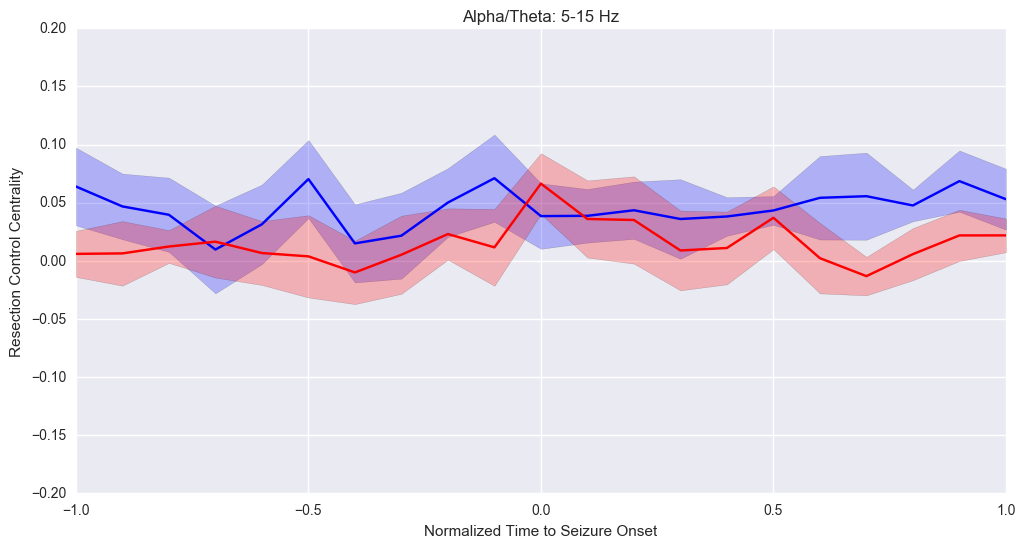

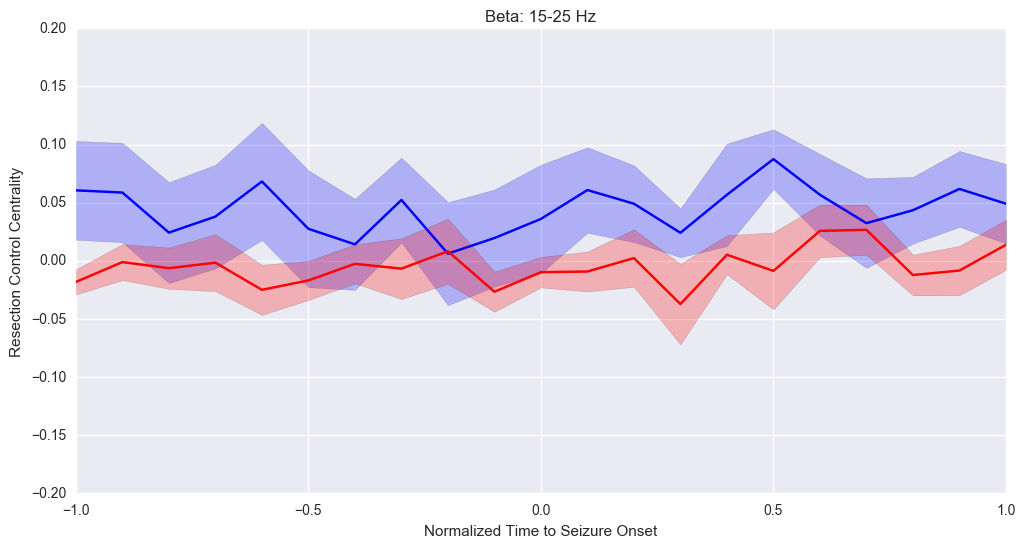

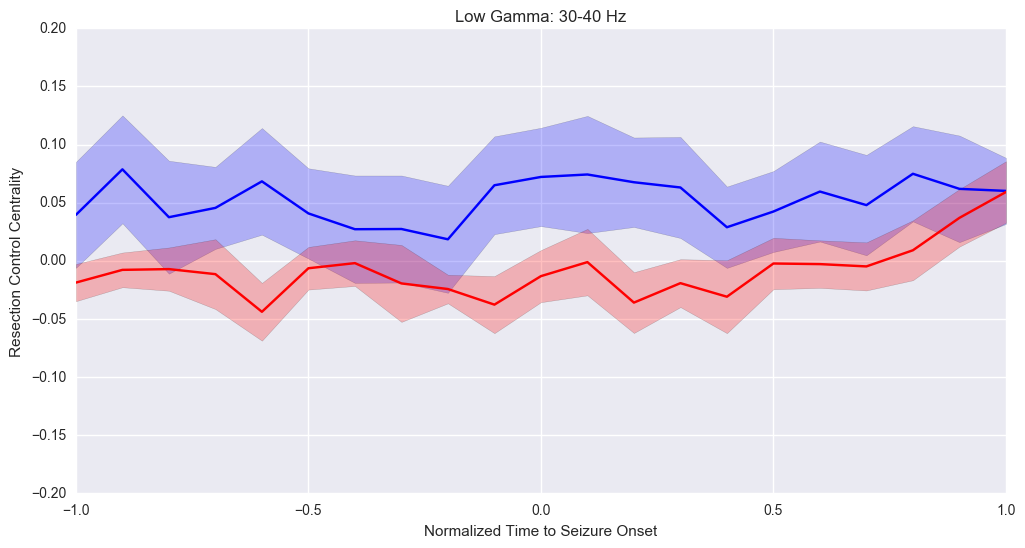

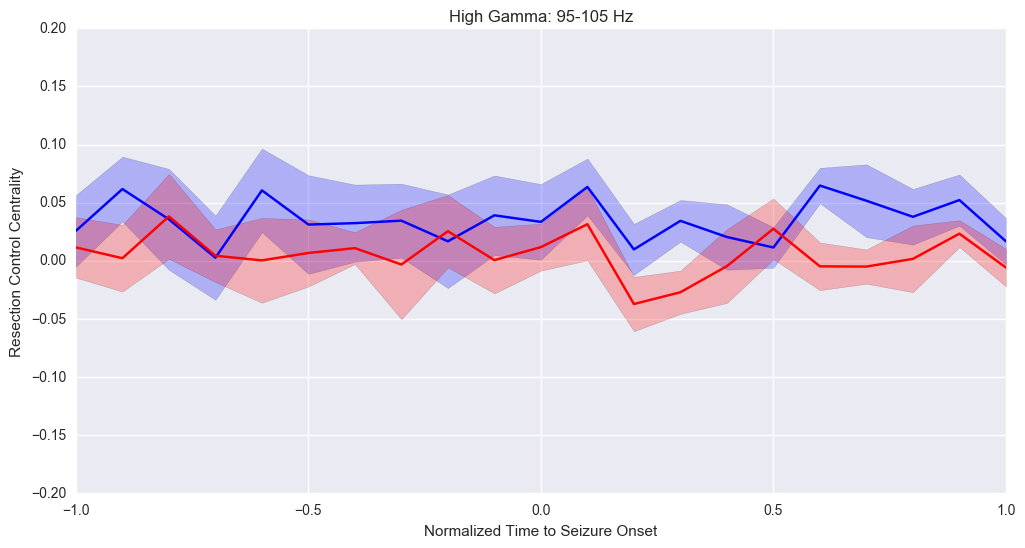

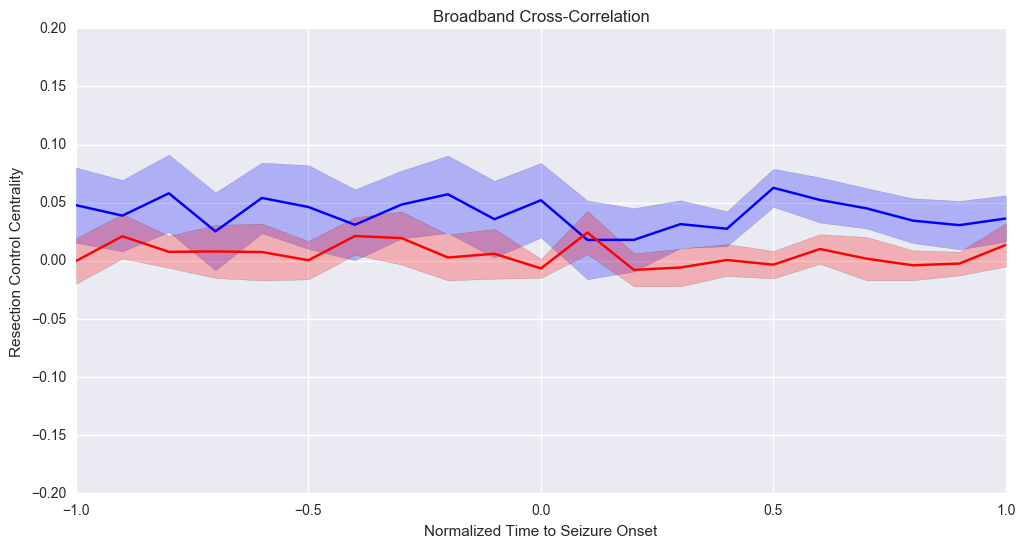

In [4]:
width = -1
for fconn in ['alphatheta','beta','lowgamma','highgamma','broadband_CC']:

    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta: 5-15 Hz'
    if(fconn == 'beta'):
        title = 'Beta: 15-25 Hz'
    if(fconn == 'lowgamma'):
        title = 'Low Gamma: 30-40 Hz'
    if(fconn == 'highgamma'):
        title = 'High Gamma: 95-105 Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband Cross-Correlation'

    skip_chop = True
    skip_mayo = False
    skip_hup = False
    dilate_radius = 0
    all_cres = gather_cres_results(dilate_radius,fconn)
    all_cres = get_norm(all_cres, width=width)
    width = len(map(lambda x: x.values(), all_cres.values())[0][0])
    num_fts = width

    pt_iter = 0
    patient_idx = all_cres.keys()
    ft_matrix = []

    out_txt = 'pt_id,' #First column
    index_col = []    

    for patient_id in sorted(patient_idx):
            if(skip_chop and 'CHOP' in patient_id):
                continue
            if(skip_mayo and 'Study' in patient_id):
                continue
            if(skip_hup and 'HUP' in patient_id):
                continue
            if not all_cres[patient_id]:
                continue
    #                 print patient_id
            index_col.append(patient_id)
            row_data = np.array((pt_iter+1,))    
            for pid,clips in sorted(all_cres.items(), key=lambda x:x[0]):                    
                if(pid != patient_id):
                    continue
                outcome = data['PATIENTS'][patient_id]['Outcome']

                avg_data = np.array(())                    
                for clip, clip_data in sorted(clips.items(), key=lambda x:x[0]):
                    res = clip_data                        
                    if(res.shape[0] == num_fts+1):
                        res = res[:num_fts]
                    try:                
                        avg_data = np.hstack((avg_data,np.reshape(res,(num_fts,1))))
                    except Exception:                
                        avg_data = np.reshape(res,(num_fts,1))                    
                avg_data = np.nanmedian(avg_data,axis=1)

                # Update row_data
                row_data = np.hstack((row_data,avg_data)) 

                # Update header
                if(pt_iter == 0):
                    for t in range(1,num_fts+1):
                        out_txt += 'base_sync_'+str(t)+'_%s,'%fconn
            if(get_outcome(outcome) == 'Good'):        
                row_data = np.hstack((row_data,[0]))        
            else:
                row_data = np.hstack((row_data,[1]))
            if(row_data.shape[0] != num_fts+2):
                continue
            ft_matrix.append(row_data)
            pt_iter += 1
    ft_matrix = np.array(ft_matrix)
    all_data = ft_matrix[:,1:width+1]
    outcomex = ft_matrix[:,width+1]
    good_outcome_data = all_data[outcomex==0,:]
    poor_outcome_data = all_data[outcomex==1,:]

    good_outcome_data_err = scipy.stats.sem(good_outcome_data,axis=0,nan_policy='omit')
    # good_outcome_data_err_low = np.nanpercentile(good_outcome_data,2.5,axis=0)
    # good_outcome_data_err_high = np.nanpercentile(good_outcome_data,97.5,axis=0)


    poor_outcome_data_err = scipy.stats.sem(poor_outcome_data,axis=0,nan_policy='omit')
    # poor_outcome_data_err_low = np.nanpercentile(poor_outcome_data,2.5,axis=0)
    # poor_outcome_data_err_high = np.nanpercentile(poor_outcome_data,97.5,axis=0)

    plt.figure(dpi=1200,figsize=(12,6))
    plt.plot(np.linspace(-1.0,1.0,num_fts),np.nanmedian(good_outcome_data,axis=0),'b')
    plt.hold(True)
    plt.fill_between(np.linspace(-1.0,1.0,num_fts),np.nanmedian(good_outcome_data,axis=0)-good_outcome_data_err,np.nanmedian(good_outcome_data,axis=0)+good_outcome_data_err,facecolor='blue',alpha=0.25)
    # plt.fill_between(np.linspace(-1.0,1.0,num_fts),good_outcome_data_err_low,good_outcome_data_err_high,facecolor='blue',alpha=0.25)
    plt.plot(np.linspace(-1.0,1.0,num_fts),np.nanmedian(poor_outcome_data,axis=0), 'r')
    plt.fill_between(np.linspace(-1.0,1.0,num_fts),np.nanmedian(poor_outcome_data,axis=0)-poor_outcome_data_err,np.nanmedian(poor_outcome_data,axis=0)+poor_outcome_data_err,facecolor='red',alpha=0.25)
    # plt.fill_between(np.linspace(-1.0,1.0,num_fts),poor_outcome_data_err_low,poor_outcome_data_err_high,facecolor='red',alpha=0.25)
    plt.xlim(( -1.0, 1.0))
    plt.ylim((-0.2, 0.2))
    plt.title(title)
    plt.xlabel('Normalized Time to Seizure Onset')
    plt.ylabel('Resection Control Centrality')
    plt.grid(True)
    # plt.show()
    plt.savefig('../../fig/Figure2B_%s.svg'%fconn,bbox_inches='tight', format='svg', dpi=1200)

In [10]:
width = -1
for fconn in ['alphatheta','beta','lowgamma','highgamma','broadband_CC']:

    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta: 5-15 Hz'
    if(fconn == 'beta'):
        title = 'Beta: 15-25 Hz'
    if(fconn == 'lowgamma'):
        title = 'Low Gamma: 30-40 Hz'
    if(fconn == 'highgamma'):
        title = 'High Gamma: 95-105 Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband Cross-Correlation'

    skip_chop = True
    skip_mayo = False
    skip_hup = False
    dilate_radius = 0
    all_cres = gather_cres_results(dilate_radius,fconn)
    all_cres = get_norm(all_cres,width=width)
    width = len(map(lambda x: x.values(), all_cres.values())[0][0])
    num_fts = width

    pt_iter = 0
    patient_idx = all_cres.keys()
    ft_matrix = []

    out_txt = 'pt_id,' #First column
    index_col = []    

    for patient_id in sorted(patient_idx):
            if(skip_chop and 'CHOP' in patient_id):
                continue
            if(skip_mayo and 'Study' in patient_id):
                continue
            if(skip_hup and 'HUP' in patient_id):
                continue
            if not all_cres[patient_id]:
                continue
    #                 print patient_id
            index_col.append(patient_id)
            row_data = np.array((pt_iter+1,))    
            for pid,clips in sorted(all_cres.items(), key=lambda x:x[0]):                    
                if(pid != patient_id):
                    continue
                outcome = data['PATIENTS'][patient_id]['Outcome']

                avg_data = np.array(())                    
                for clip, clip_data in sorted(clips.items(), key=lambda x:x[0]):
                    res = clip_data                        
                    if(res.shape[0] == num_fts+1):
                        res = res[:num_fts]
                    try:                
                        avg_data = np.hstack((avg_data,np.reshape(res,(num_fts,1))))
                    except Exception:                
                        avg_data = np.reshape(res,(num_fts,1))                    
                avg_data = np.nanmedian(avg_data,axis=1)

                # Update row_data
                row_data = np.hstack((row_data,avg_data)) 

                # Update header
                if(pt_iter == 0):
                    for t in range(1,num_fts+1):
                        out_txt += 'base_sync_'+str(t)+'_%s,'%fconn
            if(get_outcome(outcome) == 'Good'):        
                row_data = np.hstack((row_data,[0]))        
            else:
                row_data = np.hstack((row_data,[1]))
            if(row_data.shape[0] != num_fts+2):
                continue
            ft_matrix.append(row_data)
            pt_iter += 1
    ft_matrix = np.array(ft_matrix)
    all_data = ft_matrix[:,1:width+1]
    outcomex = ft_matrix[:,width+1]
    
    fpr,tpr,threshold = roc_curve(outcomex,np.nanmean(all_data[:,width/2:],axis=1))
    roc_auc = auc(fpr,tpr)
    print roc_auc

    p = curve_test(all_data[:,:width/2].T,np.where(outcomex==0)[0],np.where(outcomex==1)[0],10000)
    print fconn,'pre',p
    p = curve_test(all_data[:,width/2:].T,np.where(outcomex==0)[0],np.where(outcomex==1)[0],10000)
    print fconn,'seizure',p


0.433333333333
alphatheta pre 0.5942
alphatheta seizure 0.4791
0.255555555556
beta pre 0.2418
beta seizure 0.1043
0.344444444444
lowgamma pre 0.1433
lowgamma seizure 0.1249
0.333333333333
highgamma pre 0.7221
highgamma seizure 0.3265
0.344444444444
broadband_CC pre 0.4289
broadband_CC seizure 0.1008


<h1>Figure 6B. Control Centrality of Resection Zone in Time-Varying Functional Networks (averaged across seizures) </h1>

In [45]:
width = -1
all_features = []
roc_results = []
for fconn in ['lowgamma']:

    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta: 5-15 Hz'
    if(fconn == 'beta'):
        title = 'Beta: 15-25 Hz'
    if(fconn == 'lowgamma'):
        title = 'Low Gamma: 30-40 Hz'
    if(fconn == 'highgamma'):
        title = 'High Gamma: 95-105 Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband Cross-Correlation'

    skip_chop = True
    skip_mayo = False
    skip_hup = False
    dilate_radius = 0
    all_cres = gather_cres_results(dilate_radius,fconn)
    all_cres = get_norm(all_cres, width=width)
    width = len(map(lambda x: x.values(), all_cres.values())[0][0])
    num_fts = width

    clip_iter = 0
    patient_idx = all_cres.keys()
    ft_matrix = []

    out_txt = 'pt_id,' #First column
    index_col = []    
    clip_labels = []
    for patient_id in sorted(patient_idx):
            if(skip_chop and 'CHOP' in patient_id):
                continue
            if(skip_mayo and 'Study' in patient_id):
                continue
            if(skip_hup and 'HUP' in patient_id):
                continue
            if not all_cres[patient_id]:
                continue
    #                 print patient_id
            index_col.append(patient_id)
            
            for pid,clips in sorted(all_cres.items(), key=lambda x:x[0]):                    
                if(pid != patient_id):
                    continue
                outcome = data['PATIENTS'][patient_id]['Outcome']              
                # Create entry for each subtype
                for subtype in ['A', 'B', 'C', 'D']:
                    avg_data = np.array(())
                    for clip, clip_data in sorted(clips.items(), key=lambda x:x[0]):
                        stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip]['SeizurePhenotype']
                        if stype != subtype:
                            continue
                        res = clip_data                        
                        if(res.shape[0] == num_fts+1):
                            res = res[:num_fts]
                        try:                
                            avg_data = np.hstack((avg_data,np.reshape(res,(num_fts,1))))
                        except Exception:                
                            avg_data = np.reshape(res,(num_fts,1))                    
                    if patient_id == 'HUP107' and subtype == 'C':
                        print avg_data
                    # Check if subtype exists
                    if avg_data.shape[0] == 0:
                        continue
                    
                    #%DEBUG
#                     print patient_id, clip, avg_data.shape
                    avg_data = np.nanmedian(avg_data,axis=1)
    
                    # Update row_data
                    row_data = np.append([clip_iter+1],avg_data)
                    row_data = np.reshape(row_data, (row_data.shape[0],1))
                    # Update header
                    if(clip_iter == 0):
                        for t in range(1,num_fts+1):
                            out_txt += 'base_sync_'+str(t)+'_%s,'%fconn
                    if(get_outcome(outcome) == 'Good'):        
                        row_data = np.append(row_data,[0])        
                    else:
                        row_data = np.append(row_data,[1])
                    row_data = np.reshape(row_data, (row_data.shape[0],1))
                    try:
                        all_data = np.hstack((all_data, np.reshape(row_data,(num_fts+2,1))))
                    except Exception:
                        all_data = row_data
                    clip_iter += 1
                    clip_labels.append(patient_id+subtype)
    ft_matrix = np.array(all_data).T
    all_data = ft_matrix[:,1:width+1]
    outcomex = ft_matrix[:,width+1]
    
    res= zip(clip_labels,np.nanmean(all_data[:,width/2:],axis=1)-np.nanmean(all_data[:,:width/2],axis=1))
    open('../../fig/tmp.csv','w').write('\n'.join(map(lambda x: '%s,%0.8f'%(x[0],x[1]),res)))

print res

[]
[(u'HUP064A', 0.069415401625098308), (u'HUP068A', -0.029887783335270285), (u'HUP068B', -0.0071584613240477666), (u'HUP073A', -0.021449699480129713), (u'HUP073B', 0.00512132885342329), (u'HUP074A', -0.24599187560235167), (u'HUP074B', -0.20304224884487737), (u'HUP075A', 0.073651716082048055), (u'HUP078A', 0.11416255833823002), (u'HUP083A', 0.008617397911850927), (u'HUP083C', 0.027170817185216189), (u'HUP083D', 0.084898964213616396), (u'HUP086A', -0.078029434164420375), (u'HUP088A', 0.021206017714324045), (u'HUP088B', -0.06645676186419186), (u'HUP088C', -0.037261512571547493), (u'HUP094A', -0.0097595793401895146), (u'HUP105A', 0.044297870935128575), (u'HUP105B', 0.001428283661659209), (u'HUP106A', -0.031399911691619597), (u'HUP106B', 0.00027761846160798337), (u'HUP106C', -0.041424991378712493), (u'HUP107A', -0.073940828400780478), (u'HUP107B', -0.029620743085789068), (u'HUP111A', -0.0065468720507578688), (u'Study022A', 0.029428767108840681), (u'Study022B', 0.029449869047994182), (u'Stu

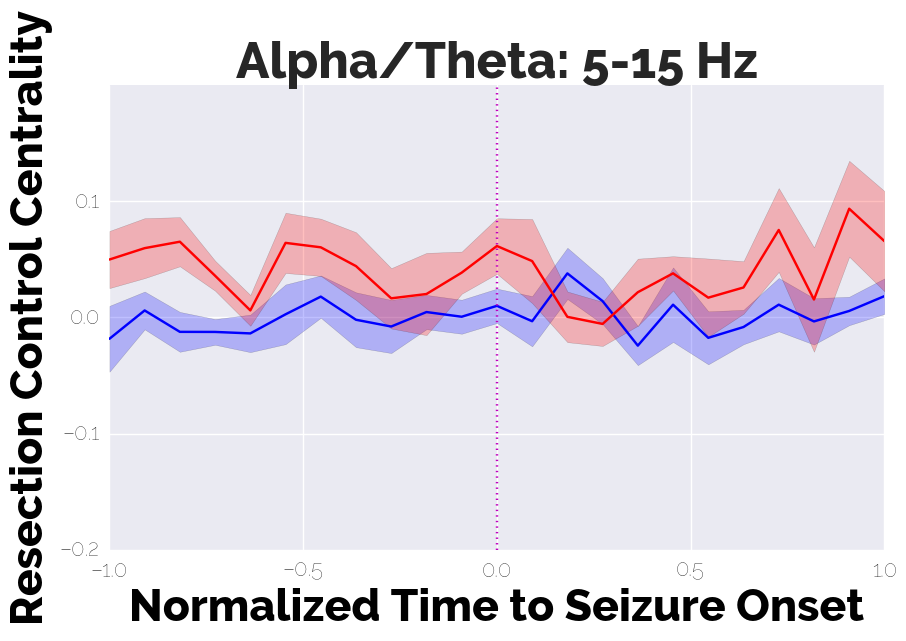

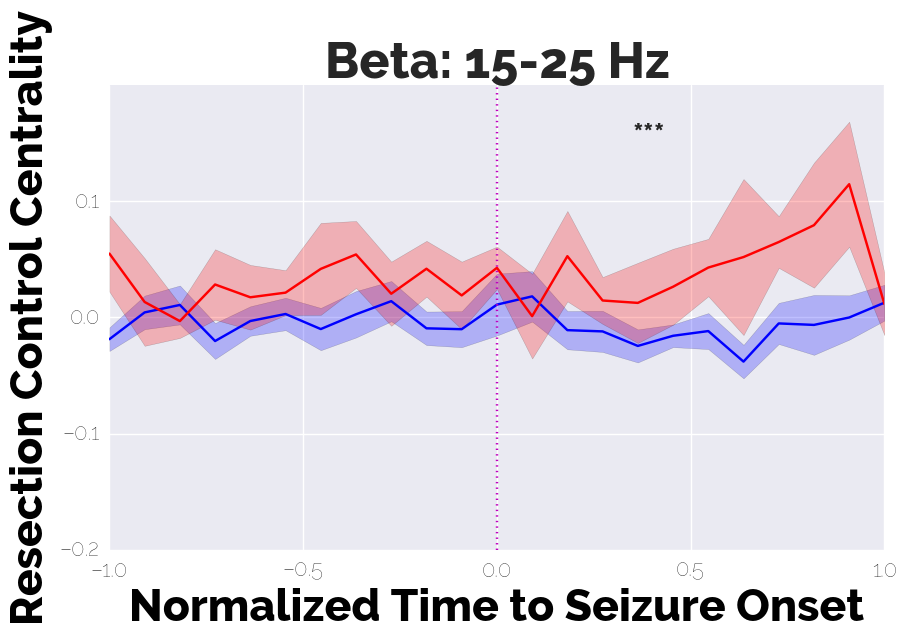

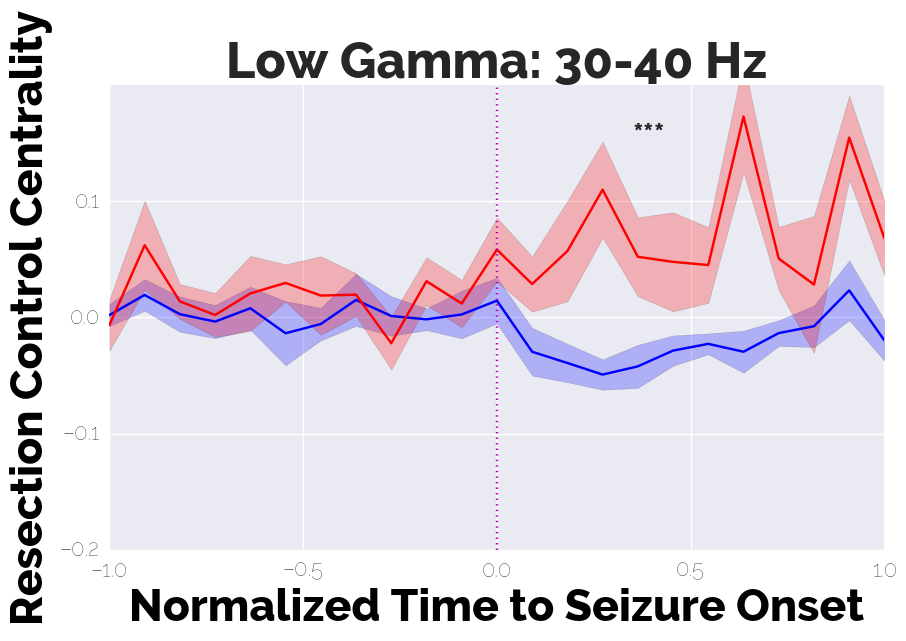

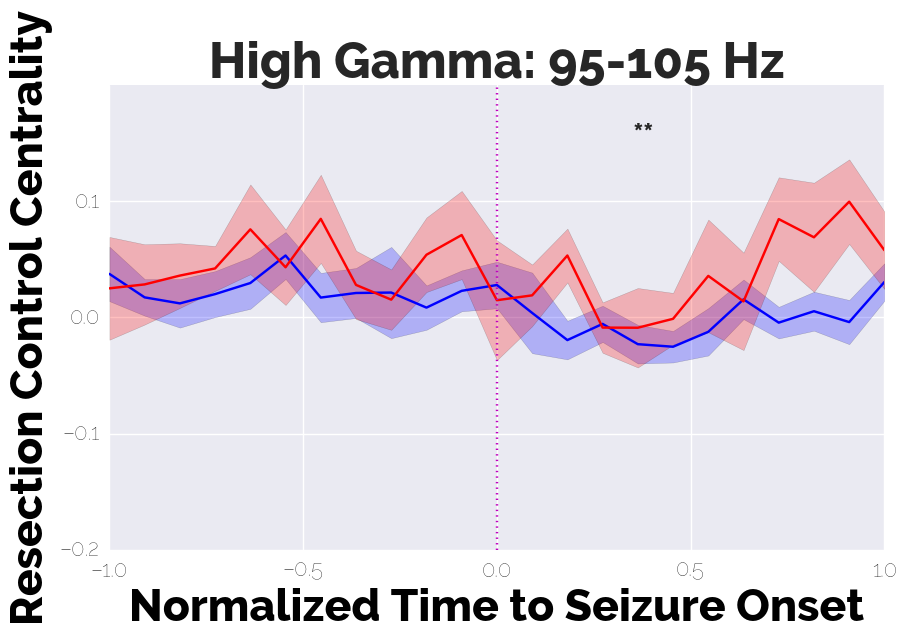

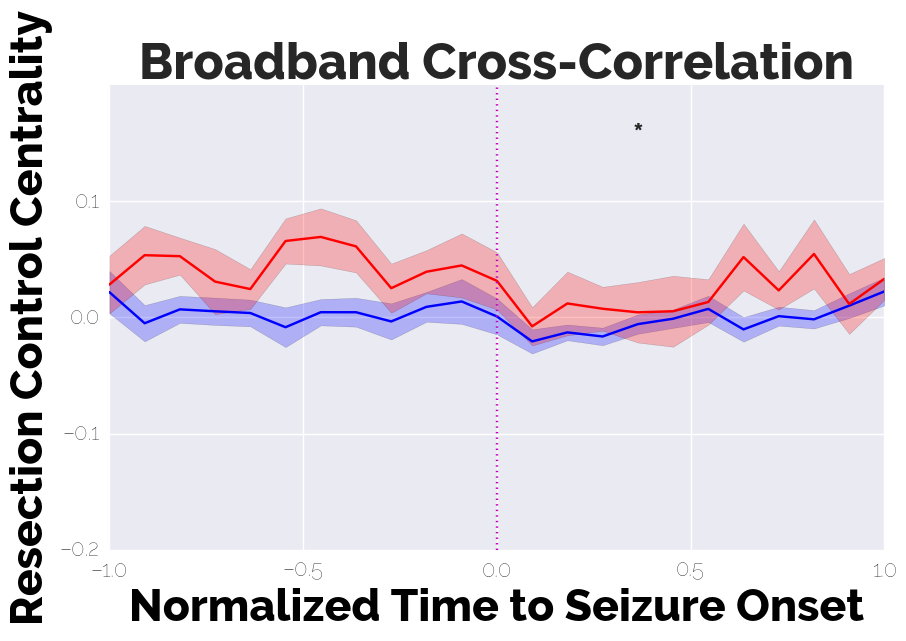

In [3]:
width = -1
for fconn in ['alphatheta','beta','lowgamma','highgamma','broadband_CC']:

    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta: 5-15 Hz'
    if(fconn == 'beta'):
        title = 'Beta: 15-25 Hz'
    if(fconn == 'lowgamma'):
        title = 'Low Gamma: 30-40 Hz'
    if(fconn == 'highgamma'):
        title = 'High Gamma: 95-105 Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband Cross-Correlation'

    skip_chop = True
    skip_mayo = False
    skip_hup = False
    dilate_radius = 0
    all_cres = gather_cres_results(dilate_radius,fconn)
    all_cres = get_norm(all_cres, width=width)
    width = len(map(lambda x: x.values(), all_cres.values())[0][0])
    num_fts = width

    clip_iter = 0
    patient_idx = all_cres.keys()
    ft_matrix = []

    out_txt = 'pt_id,' #First column
    index_col = []    

    for patient_id in sorted(patient_idx):
            if(skip_chop and 'CHOP' in patient_id):
                continue
            if(skip_mayo and 'Study' in patient_id):
                continue
            if(skip_hup and 'HUP' in patient_id):
                continue
            if not all_cres[patient_id]:
                continue
    #                 print patient_id
            index_col.append(patient_id)
            
            for pid,clips in sorted(all_cres.items(), key=lambda x:x[0]):                    
                if(pid != patient_id):
                    continue
                outcome = data['PATIENTS'][patient_id]['Outcome']              
                # Create entry for each subtype
                for subtype in ['A', 'B', 'C', 'D']:
                    avg_data = np.array(())
                    for clip, clip_data in sorted(clips.items(), key=lambda x:x[0]):
                        stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip]['SeizurePhenotype']
                        if stype != subtype:
                            continue
                        res = clip_data                        
                        if(res.shape[0] == num_fts+1):
                            res = res[:num_fts]
                        try:                
                            avg_data = np.hstack((avg_data,np.reshape(res,(num_fts,1))))
                        except Exception:                
                            avg_data = np.reshape(res,(num_fts,1))                    
                    # Check if subtype exists
                    if avg_data.shape[0] == 0:
                        continue
                    
                    #%DEBUG
#                     print patient_id, clip, avg_data.shape
                    avg_data = np.nanmedian(avg_data,axis=1)
    
                    # Update row_data
                    row_data = np.append([clip_iter+1],avg_data)
                    row_data = np.reshape(row_data, (row_data.shape[0],1))
                    # Update header
                    if(clip_iter == 0):
                        for t in range(1,num_fts+1):
                            out_txt += 'base_sync_'+str(t)+'_%s,'%fconn
                    if(get_outcome(outcome) == 'Good'):        
                        row_data = np.append(row_data,[0])        
                    else:
                        row_data = np.append(row_data,[1])
                    row_data = np.reshape(row_data, (row_data.shape[0],1))
                    try:
                        all_data = np.hstack((all_data, np.reshape(row_data,(num_fts+2,1))))
                    except Exception:
                        all_data = row_data
                    clip_iter += 1
    ft_matrix = np.array(all_data).T
    all_data = ft_matrix[:,1:width+1]
    outcomex = ft_matrix[:,width+1]
    good_outcome_data = all_data[outcomex==0,:]
    poor_outcome_data = all_data[outcomex==1,:]

    good_outcome_data_err = scipy.stats.sem(good_outcome_data,axis=0,nan_policy='omit')
    # good_outcome_data_err_low = np.nanpercentile(good_outcome_data,2.5,axis=0)
    # good_outcome_data_err_high = np.nanpercentile(good_outcome_data,97.5,axis=0)


    poor_outcome_data_err = scipy.stats.sem(poor_outcome_data,axis=0,nan_policy='omit')
    # poor_outcome_data_err_low = np.nanpercentile(poor_outcome_data,2.5,axis=0)
    # poor_outcome_data_err_high = np.nanpercentile(poor_outcome_data,97.5,axis=0)
    font = {'family' : 'Raleway',
        'weight' : 'normal',
        'size'   : 32}
    matplotlib.rc('font', **font)
    matplotlib.rcParams['axes.titlesize'] = 36
    matplotlib.rcParams['axes.titleweight'] = 'bold'
    matplotlib.rcParams['axes.labelsize'] = 32
    matplotlib.rcParams['axes.labelweight'] = 'bold'
    matplotlib.rcParams['ytick.labelsize'] = 16
    matplotlib.rcParams['xtick.labelsize'] = 16
    matplotlib.rcParams['axes.labelcolor'] = 'black'

    plt.figure(dpi=1200,figsize=(10,6))
    plt.plot(np.linspace(-1.0,1.0,num_fts),np.nanmedian(good_outcome_data,axis=0),'b')
    plt.hold(True)
    plt.fill_between(np.linspace(-1.0,1.0,num_fts),np.nanmedian(good_outcome_data,axis=0)-good_outcome_data_err,np.nanmedian(good_outcome_data,axis=0)+good_outcome_data_err,facecolor='blue',alpha=0.25)
    # plt.fill_between(np.linspace(-1.0,1.0,num_fts),good_outcome_data_err_low,good_outcome_data_err_high,facecolor='blue',alpha=0.25)
    plt.plot(np.linspace(-1.0,1.0,num_fts),np.nanmedian(poor_outcome_data,axis=0), 'r')
    plt.fill_between(np.linspace(-1.0,1.0,num_fts),np.nanmedian(poor_outcome_data,axis=0)-poor_outcome_data_err,np.nanmedian(poor_outcome_data,axis=0)+poor_outcome_data_err,facecolor='red',alpha=0.25)
    # plt.fill_between(np.linspace(-1.0,1.0,num_fts),poor_outcome_data_err_low,poor_outcome_data_err_high,facecolor='red',alpha=0.25)
    plt.xlim(( -1.0, 1.0))
    plt.ylim((-0.2, 0.2))
    plt.plot([0,0],[-0.2,0.2],color='m',linestyle=':')
    plt.yticks(np.arange(-0.2,0.2,0.1))
    plt.title(title)
    plt.xlabel('Normalized Time to Seizure Onset')
    plt.ylabel('Resection Control Centrality')
    plt.grid(True)
    
    # Make significance indicators
    fpr,tpr,threshold = roc_curve(outcomex,np.nanmean(all_data[:,width/2:],axis=1)-np.nanmean(all_data[:,:width/2],axis=1))    
    roc_auc = auc(fpr,tpr)
    pre_p = curve_test(all_data[:,:all_data.shape[0]/2].T,np.where(outcomex==0)[0],np.where(outcomex==1)[0],10000)
    post_p = curve_test(all_data[:,all_data.shape[0]/2:].T,np.where(outcomex==0)[0],np.where(outcomex==1)[0],10000)
    if pre_p < 0.001:
        plt.text(-0.65,0.15, '***',{'weight':'bold', 'size':22})
    elif pre_p < 0.01:
        plt.text(-0.65,0.15, '**',{'weight':'bold', 'size':22})
    elif pre_p < 0.05:
        plt.text(-0.65,0.15, '*',{'weight':'bold', 'size':22})
    elif pre_p < 0.1:
        plt.text(-0.65,0.15, 'p=%0.2f'%pre_p,{'weight':'normal', 'size':22})
    
    if post_p < 0.001:
        plt.text(0.35,0.15, '***',{'weight':'bold', 'size':22})
    elif post_p < 0.01:
        plt.text(0.35,0.15, '**',{'weight':'bold', 'size':22})
    elif post_p < 0.05:
        plt.text(0.35,0.15, '*',{'weight':'bold', 'size':22})
    elif post_p < 0.1:
        plt.text(0.35,0.15, 'p=%0.2f'%post_p,{'weight':'normal', 'size':22})
    plt.savefig('../../fig/Figure6B_%s.svg'%fconn,bbox_inches='tight', format='svg', dpi=1200)


In [5]:
width = -1
for fconn in ['alphatheta','beta','lowgamma','highgamma','broadband_CC']:

    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta: 5-15 Hz'
    if(fconn == 'beta'):
        title = 'Beta: 15-25 Hz'
    if(fconn == 'lowgamma'):
        title = 'Low Gamma: 30-40 Hz'
    if(fconn == 'highgamma'):
        title = 'High Gamma: 95-105 Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband Cross-Correlation'

    skip_chop = True
    skip_mayo = False
    skip_hup = False
    dilate_radius = 0
    all_cres = gather_cres_results(dilate_radius,fconn)
    all_cres = get_norm(all_cres, width=width)
    width = len(map(lambda x: x.values(), all_cres.values())[0][0])
    num_fts = width

    clip_iter = 0
    patient_idx = all_cres.keys()
    ft_matrix = []

    out_txt = 'pt_id,' #First column
    index_col = []    

    for patient_id in sorted(patient_idx):
            if(skip_chop and 'CHOP' in patient_id):
                continue
            if(skip_mayo and 'Study' in patient_id):
                continue
            if(skip_hup and 'HUP' in patient_id):
                continue
            if not all_cres[patient_id]:
                continue
    #                 print patient_id
            index_col.append(patient_id)
            
            for pid,clips in sorted(all_cres.items(), key=lambda x:x[0]):                    
                if(pid != patient_id):
                    continue
                outcome = data['PATIENTS'][patient_id]['Outcome']              
                # Create entry for each subtype
                for subtype in ['A', 'B', 'C', 'D']:
                    avg_data = np.array(())
                    for clip, clip_data in sorted(clips.items(), key=lambda x:x[0]):
                        stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip]['SeizurePhenotype']
                        if stype != subtype:
                            continue
                        res = clip_data                        
                        if(res.shape[0] == num_fts+1):
                            res = res[:num_fts]
                        try:                
                            avg_data = np.hstack((avg_data,np.reshape(res,(num_fts,1))))
                        except Exception:                
                            avg_data = np.reshape(res,(num_fts,1))                    
                    # Check if subtype exists
                    if avg_data.shape[0] == 0:
                        continue
                    
                    #%DEBUG
#                     print patient_id, clip, avg_data.shape
                    avg_data = np.nanmedian(avg_data,axis=1)
    
                    # Update row_data
                    row_data = np.append([clip_iter+1],avg_data)
                    row_data = np.reshape(row_data, (row_data.shape[0],1))
                    # Update header
                    if(clip_iter == 0):
                        for t in range(1,num_fts+1):
                            out_txt += 'base_sync_'+str(t)+'_%s,'%fconn
                    if(get_outcome(outcome) == 'Good'):        
                        row_data = np.append(row_data,[0])        
                    else:
                        row_data = np.append(row_data,[1])
                    row_data = np.reshape(row_data, (row_data.shape[0],1))
                    try:
                        all_data = np.hstack((all_data, np.reshape(row_data,(num_fts+2,1))))
                    except Exception:
                        all_data = row_data
                    clip_iter += 1
    ft_matrix = np.array(all_data).T
    all_data = ft_matrix[:,1:width+1]
    outcomex = ft_matrix[:,width+1]
    
    fpr,tpr,threshold = roc_curve(outcomex,np.nanmean(all_data[:,width/2:],axis=1)-np.nanmean(all_data[:,:width/2],axis=1))
    roc_auc = auc(fpr,tpr)
    print roc_auc

    p = curve_test(all_data[:,:width/2].T,np.where(outcomex==0)[0],np.where(outcomex==1)[0],10000)
    print fconn,'pre',p
    p = curve_test(all_data[:,width/2:].T,np.where(outcomex==0)[0],np.where(outcomex==1)[0],10000)
    print fconn,'seizure',p


0.48125
alphatheta pre 0.2588
alphatheta seizure 0.1159
0.64375
beta pre 0.2182
beta seizure 0.0005
0.90625
lowgamma pre 0.7405
lowgamma seizure 0.0
0.6375
highgamma pre 0.6495
highgamma seizure 0.0155
0.54375
broadband_CC pre 0.2361
broadband_CC seizure 0.028


<h1> Figure 9 </h1>

In [12]:
gather_cres_results(-15,'lowgamma')

e4bafafb-5676-4d23-99b1-679b72b60044
0c862a2c-7b2d-4e34-8759-48c3ce53a63d
79e0549c-5c4f-42c7-8f50-8c76da335a4b
0f3998bb-2a95-4490-b8e0-7e621fd389b5
ee3729b5-b9fe-42d8-8706-25dc4d53a458
18e49a9c-6462-4c7b-85fc-8e864d0a622d
b9dcce7f-1a29-42cd-9dc8-48849de52ab0
f289b44d-756e-4f5b-a1fd-229d778b3c5a
a731edeb-1d60-4f1e-b115-06a486fe6393
bf6df122-2c20-48af-aa03-06eb81891307
94c9617a-8e08-4deb-9b88-d10fcd5502a3
c75236da-9f1f-4132-8e5b-dff46d7c0b04
25366848-fd2d-4bb1-84d1-f1dff4f886eb
6dc35b30-cf59-4b6a-a1db-6fe930d886dc


{u'HUP064': {u'1': array([  1.77592240e-02,  -2.36453975e-02,  -4.81872153e-02,
          -1.19091463e-02,  -2.84395298e-02,  -4.89818929e-03,
          -5.58455936e-02,  -2.29933714e-02,  -9.43881797e-03,
          -2.63513546e-03,  -6.79718867e-03,  -1.20744828e-02,
          -3.07141131e-02,  -7.67927041e-03,   8.08638340e-03,
          -2.38250330e-02,  -2.06070018e-02,  -2.17278805e-02,
          -1.55815659e-03,  -1.11644088e-02,  -2.23098918e-02,
          -1.01127182e-02,  -1.83456049e-03,   7.39421475e-02,
          -1.51894857e-02,  -1.15773028e-02,  -1.83610328e-02,
          -5.20091021e-04,  -2.04584128e-02,  -7.96637486e-03,
          -1.50399444e-02,  -7.89100753e-03,  -2.49013720e-02,
           2.87824113e-03,   5.64445001e-03,  -1.77580199e-02,
          -3.81133819e-03,   1.75449698e-02,  -1.94667521e-02,
          -3.41425458e-02,  -5.74429157e-03,  -1.03625298e-02,
          -6.61859565e-03,  -9.84101600e-03,   1.06111332e-02,
          -2.32899266e-03,  -2.3870387

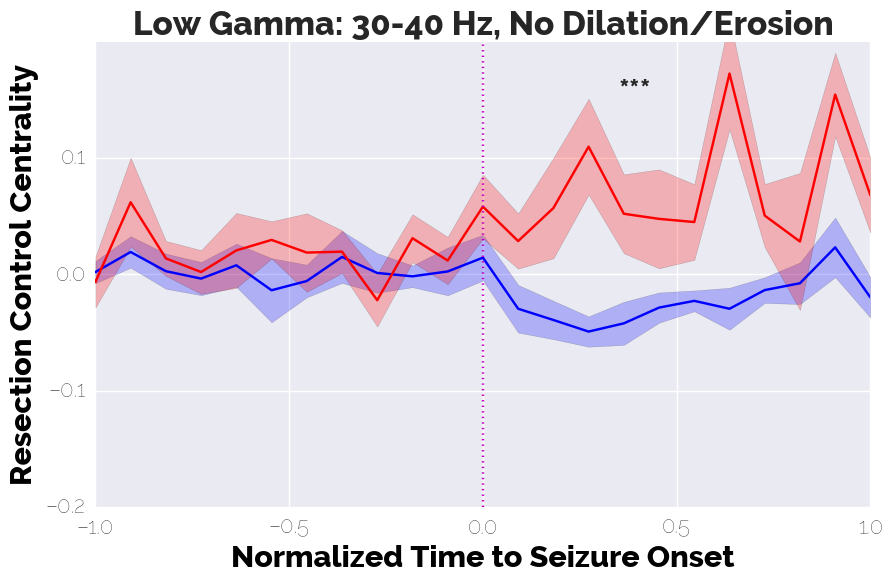

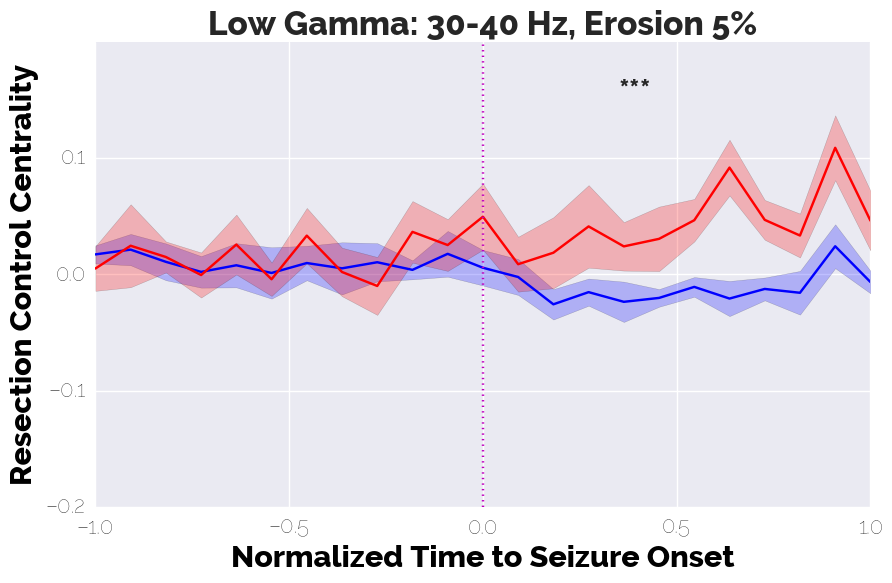

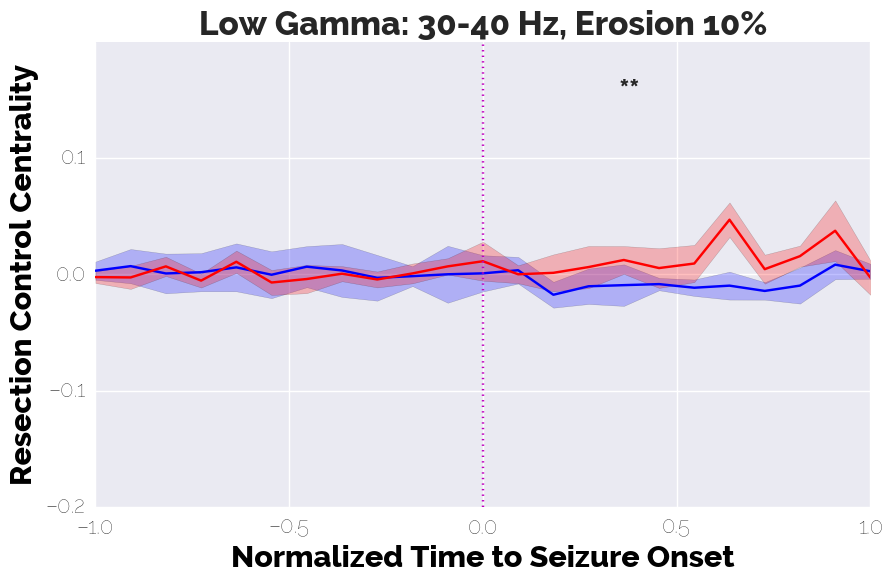

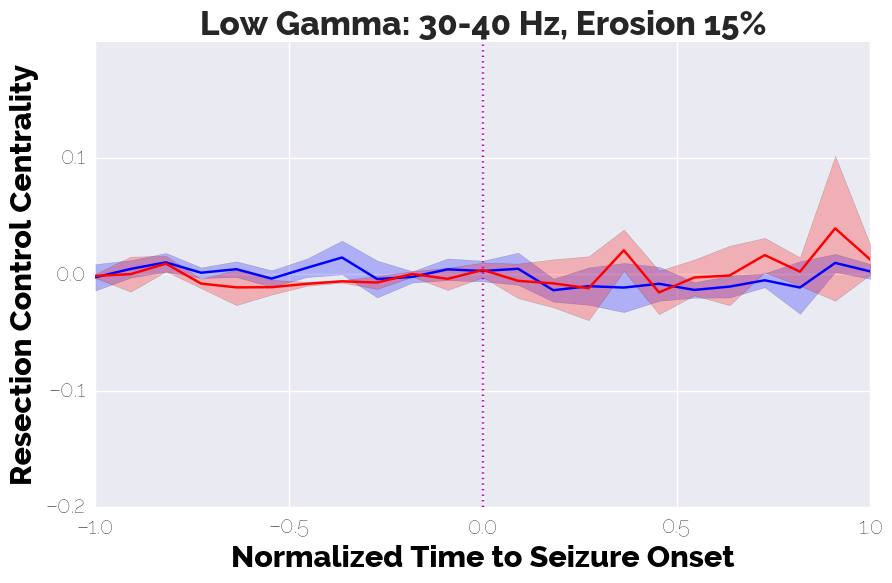

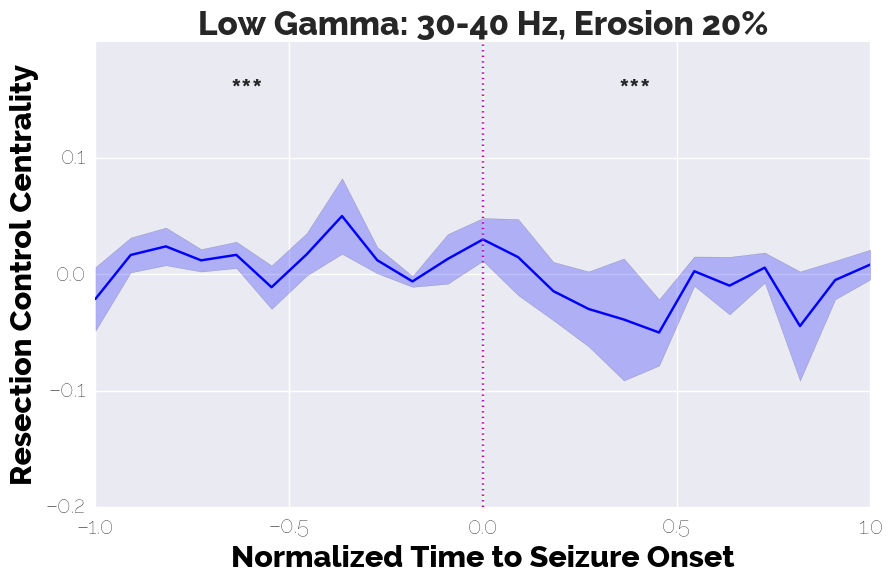

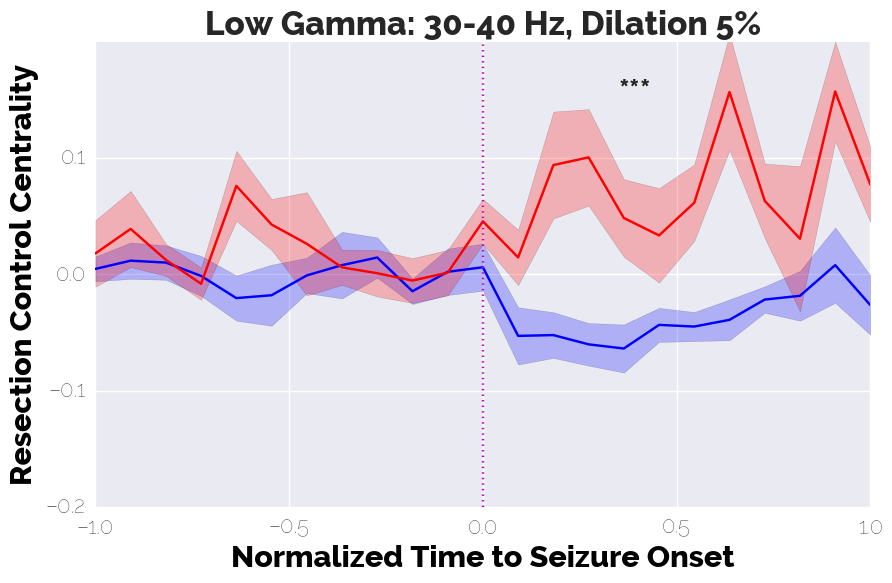

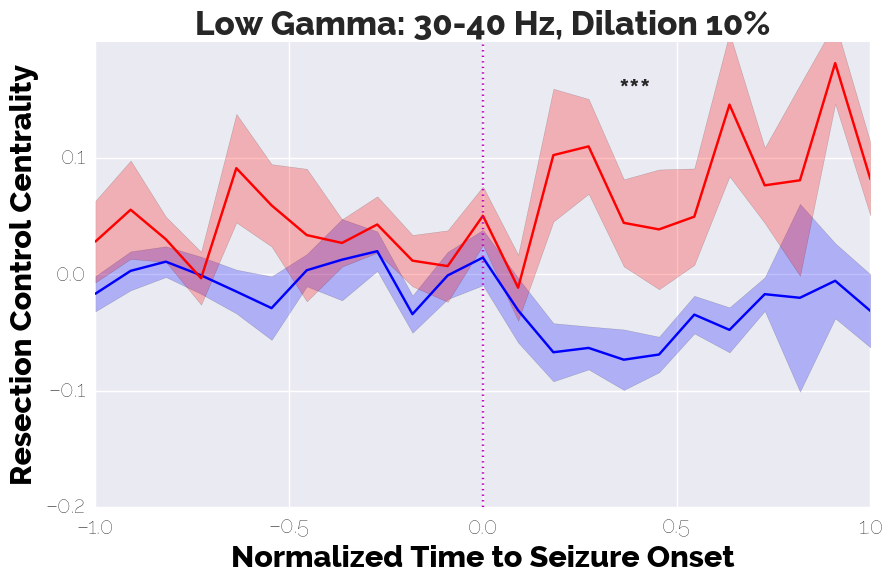

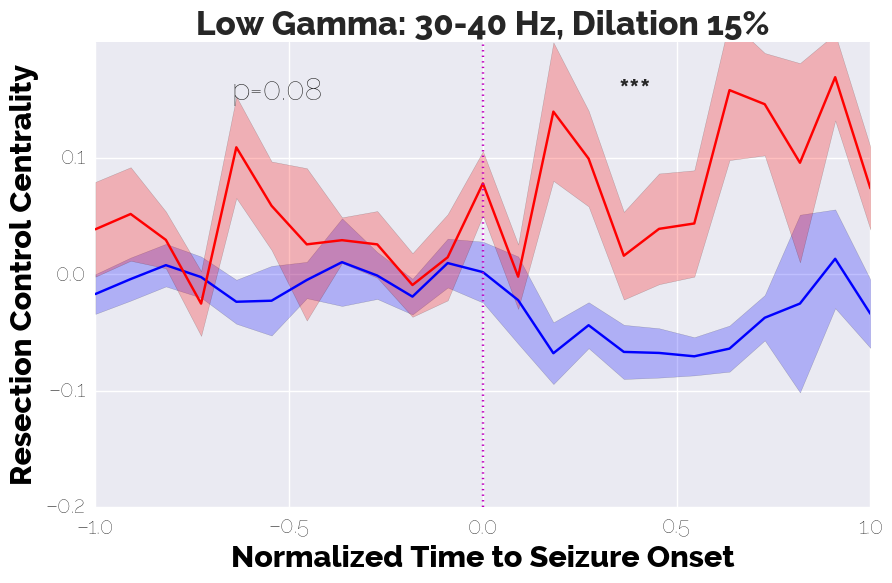

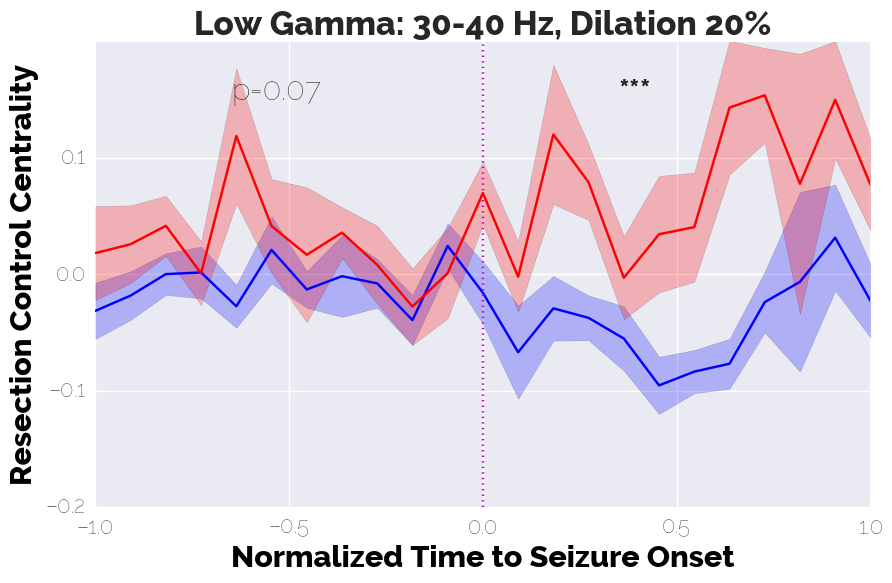

In [7]:
width = -1
for dilate_radius in [0,-5,-10,-15,-20,5,10,15,20]:
    fconn = 'lowgamma'

    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta: 5-15 Hz'
    if(fconn == 'beta'):
        title = 'Beta: 15-25 Hz'
    if(fconn == 'lowgamma'):
        if dilate_radius < 0:
            title = 'Low Gamma: 30-40 Hz, Erosion %i%%'%(np.abs(dilate_radius))
        elif dilate_radius > 0:
            title = 'Low Gamma: 30-40 Hz, Dilation %i%%'%(dilate_radius)
        else:
            title = 'Low Gamma: 30-40 Hz, No Dilation/Erosion'
    if(fconn == 'highgamma'):
        title = 'High Gamma: 95-105 Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband Cross-Correlation'

    skip_chop = True
    skip_mayo = False
    skip_hup = False
    all_cres = gather_cres_results(dilate_radius,fconn)
    all_cres = get_norm(all_cres, width=width)
    width = len(map(lambda x: x.values(), all_cres.values())[0][0])
    num_fts = width

    clip_iter = 0
    patient_idx = all_cres.keys()
    ft_matrix = []

    out_txt = 'pt_id,' #First column
    index_col = []    

    for patient_id in sorted(patient_idx):
            if(skip_chop and 'CHOP' in patient_id):
                continue
            if(skip_mayo and 'Study' in patient_id):
                continue
            if(skip_hup and 'HUP' in patient_id):
                continue
            if not all_cres[patient_id]:
                continue
    #                 print patient_id
            index_col.append(patient_id)
            
            for pid,clips in sorted(all_cres.items(), key=lambda x:x[0]):                    
                if(pid != patient_id):
                    continue
                outcome = data['PATIENTS'][patient_id]['Outcome']              
                # Create entry for each subtype
                for subtype in ['A', 'B', 'C', 'D']:
                    avg_data = np.array(())
                    for clip, clip_data in sorted(clips.items(), key=lambda x:x[0]):
                        stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip]['SeizurePhenotype']
                        if stype != subtype:
                            continue
                        res = clip_data                        
                        if(res.shape[0] == num_fts+1):
                            res = res[:num_fts]
                        try:                
                            avg_data = np.hstack((avg_data,np.reshape(res,(num_fts,1))))
                        except Exception:                
                            avg_data = np.reshape(res,(num_fts,1))                    
                    # Check if subtype exists
                    if avg_data.shape[0] == 0:
                        continue
                    
                    #%DEBUG
#                     print patient_id, clip, avg_data.shape
                    avg_data = np.nanmedian(avg_data,axis=1)
                    if np.nanmean(avg_data) == 0:
                        continue
    
                    # Update row_data
                    row_data = np.append([clip_iter+1],avg_data)
                    row_data = np.reshape(row_data, (row_data.shape[0],1))
                    # Update header
                    if(clip_iter == 0):
                        for t in range(1,num_fts+1):
                            out_txt += 'base_sync_'+str(t)+'_%s,'%fconn
                    if(get_outcome(outcome) == 'Good'):        
                        row_data = np.append(row_data,[0])        
                    else:
                        row_data = np.append(row_data,[1])
                    row_data = np.reshape(row_data, (row_data.shape[0],1))
                    try:
                        all_data = np.hstack((all_data, np.reshape(row_data,(num_fts+2,1))))
                    except Exception:
                        all_data = row_data
                    clip_iter += 1
    ft_matrix = np.array(all_data).T
    all_data = ft_matrix[:,1:width+1]
    outcomex = ft_matrix[:,width+1]
    good_outcome_data = all_data[outcomex==0,:]
    poor_outcome_data = all_data[outcomex==1,:]

    good_outcome_data_err = scipy.stats.sem(good_outcome_data,axis=0,nan_policy='omit')
    # good_outcome_data_err_low = np.nanpercentile(good_outcome_data,2.5,axis=0)
    # good_outcome_data_err_high = np.nanpercentile(good_outcome_data,97.5,axis=0)


    poor_outcome_data_err = scipy.stats.sem(poor_outcome_data,axis=0,nan_policy='omit')
    # poor_outcome_data_err_low = np.nanpercentile(poor_outcome_data,2.5,axis=0)
    # poor_outcome_data_err_high = np.nanpercentile(poor_outcome_data,97.5,axis=0)
    font = {'family' : 'Raleway',
        'weight' : 'normal',
        'size'   : 32}
    matplotlib.rc('font', **font)
    matplotlib.rcParams['axes.titlesize'] = 24
    matplotlib.rcParams['axes.labelsize'] = 22
    matplotlib.rcParams['ytick.labelsize'] = 16
    matplotlib.rcParams['xtick.labelsize'] = 16
    matplotlib.rcParams['axes.labelcolor'] = 'black'

    plt.figure(dpi=1200,figsize=(10,6))
    plt.plot(np.linspace(-1.0,1.0,num_fts),np.nanmedian(good_outcome_data,axis=0),'b')
    plt.hold(True)
    plt.fill_between(np.linspace(-1.0,1.0,num_fts),np.nanmedian(good_outcome_data,axis=0)-good_outcome_data_err,np.nanmedian(good_outcome_data,axis=0)+good_outcome_data_err,facecolor='blue',alpha=0.25)
    # plt.fill_between(np.linspace(-1.0,1.0,num_fts),good_outcome_data_err_low,good_outcome_data_err_high,facecolor='blue',alpha=0.25)
    plt.plot(np.linspace(-1.0,1.0,num_fts),np.nanmedian(poor_outcome_data,axis=0), 'r')
    plt.fill_between(np.linspace(-1.0,1.0,num_fts),np.nanmedian(poor_outcome_data,axis=0)-poor_outcome_data_err,np.nanmedian(poor_outcome_data,axis=0)+poor_outcome_data_err,facecolor='red',alpha=0.25)
    # plt.fill_between(np.linspace(-1.0,1.0,num_fts),poor_outcome_data_err_low,poor_outcome_data_err_high,facecolor='red',alpha=0.25)
    plt.xlim(( -1.0, 1.0))
    plt.ylim((-0.2, 0.2))
    plt.plot([0,0],[-0.2,0.2],color='m',linestyle=':')
    plt.yticks(np.arange(-0.2,0.2,0.1))
    plt.title(title)
    plt.xlabel('Normalized Time to Seizure Onset')
    plt.ylabel('Resection Control Centrality')
    plt.grid(True)
    
    # Make significance indicators
    fpr,tpr,threshold = roc_curve(outcomex,np.nanmean(all_data[:,width/2:],axis=1)-np.nanmean(all_data[:,:width/2],axis=1))    
    roc_auc = auc(fpr,tpr)
    pre_p = curve_test(all_data[:,:all_data.shape[0]/2].T,np.where(outcomex==0)[0],np.where(outcomex==1)[0],10000)
    post_p = curve_test(all_data[:,all_data.shape[0]/2:].T,np.where(outcomex==0)[0],np.where(outcomex==1)[0],10000)
    if pre_p < 0.001:
        plt.text(-0.65,0.15, '***',{'weight':'bold', 'size':22})
    elif pre_p < 0.01:
        plt.text(-0.65,0.15, '**',{'weight':'bold', 'size':22})
    elif pre_p < 0.05:
        plt.text(-0.65,0.15, '*',{'weight':'bold', 'size':22})
    elif pre_p < 0.1:
        plt.text(-0.65,0.15, 'p=%0.2f'%pre_p,{'weight':'normal', 'size':22})
    
    if post_p < 0.001:
        plt.text(0.35,0.15, '***',{'weight':'bold', 'size':22})
    elif post_p < 0.01:
        plt.text(0.35,0.15, '**',{'weight':'bold', 'size':22})
    elif post_p < 0.05:
        plt.text(0.35,0.15, '*',{'weight':'bold', 'size':22})
    elif post_p < 0.1:
        plt.text(0.35,0.15, 'p=%0.2f'%post_p,{'weight':'normal', 'size':22})
#     plt.show()
    plt.savefig('../../fig/Figure9A_%s_%i.svg'%(fconn,dilate_radius),bbox_inches='tight', format='svg', dpi=1200)


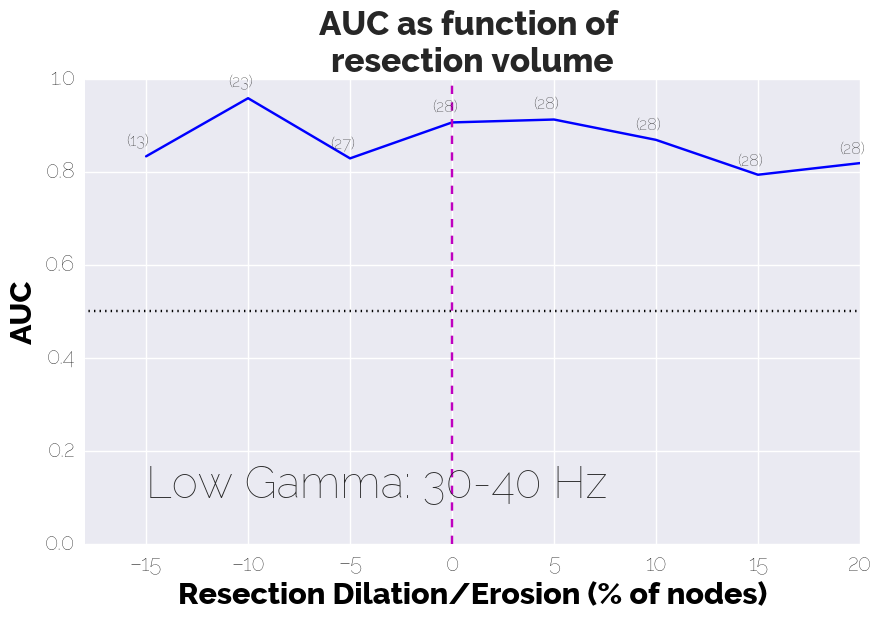

In [6]:
width = -1
results = []
fconn = 'lowgamma'

if(fconn == 'alphatheta'):
    title = 'Alpha/Theta: 5-15 Hz'
if(fconn == 'beta'):
    title = 'Beta: 15-25 Hz'
if(fconn == 'lowgamma'):
    title = 'Low Gamma: 30-40 Hz'
if(fconn == 'highgamma'):
    title = 'High Gamma: 95-105 Hz'
if(fconn == 'broadband_CC'):
    title = 'Broadband Cross-Correlation'
for dilate_radius in [0,-5,-10,-15,-20,5,10,15,20]:
    skip_chop = True
    skip_mayo = False
    skip_hup = False
    all_cres = gather_cres_results(dilate_radius,fconn)
    all_cres = get_norm(all_cres, width=width)
    width = len(map(lambda x: x.values(), all_cres.values())[0][0])
    num_fts = width

    clip_iter = 0
    patient_idx = all_cres.keys()
    ft_matrix = []

    out_txt = 'pt_id,' #First column
    index_col = []    

    for patient_id in sorted(patient_idx):
            if(skip_chop and 'CHOP' in patient_id):
                continue
            if(skip_mayo and 'Study' in patient_id):
                continue
            if(skip_hup and 'HUP' in patient_id):
                continue
            if not all_cres[patient_id]:
                continue
    #                 print patient_id
            index_col.append(patient_id)
            
            for pid,clips in sorted(all_cres.items(), key=lambda x:x[0]):                    
                if(pid != patient_id):
                    continue
                outcome = data['PATIENTS'][patient_id]['Outcome']              
                # Create entry for each subtype
                for subtype in ['A', 'B', 'C', 'D']:
                    avg_data = np.array(())
                    for clip, clip_data in sorted(clips.items(), key=lambda x:x[0]):
                        stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip]['SeizurePhenotype']
                        if stype != subtype:
                            continue
                        res = clip_data                        
                        if(res.shape[0] == num_fts+1):
                            res = res[:num_fts]
                        try:                
                            avg_data = np.hstack((avg_data,np.reshape(res,(num_fts,1))))
                        except Exception:                
                            avg_data = np.reshape(res,(num_fts,1))                    
                    # Check if subtype exists
                    if avg_data.shape[0] == 0:
                        continue
                    
                    #%DEBUG
#                     print patient_id, clip, avg_data.shape
                    avg_data = np.nanmedian(avg_data,axis=1)
    
                    if np.nanmean(avg_data) == 0 and dilate_radius < 0:
                        continue
    
                    # Update row_data
                    row_data = np.append([clip_iter+1],avg_data)
                    row_data = np.reshape(row_data, (row_data.shape[0],1))
                    # Update header
                    if(clip_iter == 0):
                        for t in range(1,num_fts+1):
                            out_txt += 'base_sync_'+str(t)+'_%s,'%fconn
                    if(get_outcome(outcome) == 'Good'):        
                        row_data = np.append(row_data,[0])        
                    else:
                        row_data = np.append(row_data,[1])
                    row_data = np.reshape(row_data, (row_data.shape[0],1))
                    try:
                        all_data = np.hstack((all_data, np.reshape(row_data,(num_fts+2,1))))
                    except Exception:
                        all_data = row_data
                    clip_iter += 1
    ft_matrix = np.array(all_data).T
    all_data = ft_matrix[:,1:width+1]
    outcomex = ft_matrix[:,width+1]
    good_outcome_data = all_data[outcomex==0,:]
    poor_outcome_data = all_data[outcomex==1,:]

    good_outcome_data_err = scipy.stats.sem(good_outcome_data,axis=0,nan_policy='omit')
    # good_outcome_data_err_low = np.nanpercentile(good_outcome_data,2.5,axis=0)
    # good_outcome_data_err_high = np.nanpercentile(good_outcome_data,97.5,axis=0)


    poor_outcome_data_err = scipy.stats.sem(poor_outcome_data,axis=0,nan_policy='omit')
    # poor_outcome_data_err_low = np.nanpercentile(poor_outcome_data,2.5,axis=0)
    # poor_outcome_data_err_high = np.nanpercentile(poor_outcome_data,97.5,axis=0)
    
    # Make significance indicators
    fpr,tpr,threshold = roc_curve(outcomex,np.nanmean(all_data[:,width/2:],axis=1)-np.nanmean(all_data[:,:width/2],axis=1))    
    roc_auc = auc(fpr,tpr)
    results.append((dilate_radius,roc_auc,all_data.shape[0]))
#     results.append((dilate_radius,roc_auc))
font = {'family' : 'Raleway',
        'weight' : 'normal',
        'size'   : 32}
matplotlib.rc('font', **font)
matplotlib.rcParams['axes.titlesize'] = 24
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['axes.labelcolor'] = 'black'

plt.figure(dpi=1200,figsize=(10,6))
results = sorted(results,key= lambda x: x[0])
results = np.array(results)
plt.plot(np.arange(-20.0,25.0,5.0),results[:,1],'b-')
plt.hold(True)

plt.xlim((-18.0, 20.0))
plt.ylim((0.0, 1.0))
plt.plot([-20.0,20.0],[0.5,0.5],color='k',linestyle=':')
plt.plot([0.0,0.0],[0.0,1.0],color='m',linestyle='--')
plt.title('AUC as function of \nresection volume')
plt.text(-15.0,0.1,title)

for ii in range(len(results)):
    if not np.isnan(results[ii,1]):
        plt.text(results[ii,0]-1.0,results[ii,1]*1.025,'(%i)'%results[ii,2],fontdict={'size':12,'weight':'normal'})

plt.xlabel('Resection Dilation/Erosion (% of nodes)')
plt.ylabel('AUC')
plt.grid(True)
# plt.show()
plt.savefig('../../fig/Figure9B.svg',bbox_inches='tight')

In [23]:
results

[(0, 0.90624999999999989, 28),
 (-5, 0.82894736842105265, 27),
 (-10, 0.97115384615384615, 21),
 (-15, 0.83333333333333326, 13),
 (-20, nan, 4),
 (5, 0.91249999999999998, 28),
 (10, 0.86875000000000002, 28),
 (15, 0.79374999999999996, 28),
 (20, 0.81874999999999998, 28)]

<h1> Figure 5 Nodal Control Centrality as a function of Time and Frequence </h1>

In [14]:
all_nodal_results = gather_nodal_results(fconn='highgamma')
PATIENT_IDX = all_nodal_results.keys()
comp_dir = os.path.expanduser(data['COMP_DIR'])

# Collect data
# Initialize boxplot arrays
good_pre_res = {}
good_pre_non_res = {}
good_res = {}
good_non_res = {}
poor_pre_res = {}
poor_pre_non_res = {}
poor_res = {}
poor_non_res = {}

for ax, fconn in zip(axs,['alphatheta','beta','lowgamma','highgamma','broadband_CC']):
    # All nodal results
    all_nodal_results = gather_nodal_results(fconn=fconn)
    try:
        good_pre_res[fconn]        
    except KeyError:
        good_pre_res[fconn] = []
        good_pre_non_res[fconn] = []
        good_res[fconn] = []
        good_non_res[fconn] = []
        poor_pre_res[fconn] = []
        poor_pre_non_res[fconn] = []
        poor_res[fconn] = []
        poor_non_res[fconn] = []        
    for patient_id in PATIENT_IDX:
        # Create figure
        outcome = data['PATIENTS'][patient_id]['Outcome']
        outcome = get_outcome(outcome)
        if outcome == 'Good':
            # Load event
            for clip_id in data['PATIENTS'][patient_id]['Events']['Ictal'].keys():
                stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]['SeizurePhenotype']
                if stype not in ['A','B','C','D']:
                    continue
                stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]['SeizureType']
                if 'CPS' not in stype or stype == '??':
                    continue
                event = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]
                try:
                    nodal_control_centrality = all_nodal_results[patient_id][clip_id]
                except KeyError:
                    continue

                resected_node_idx, channels = get_resected_node_dx(patient_id)
                non_resected_node_idx = []
                for k in range(nodal_control_centrality.shape[0]):
                    if k not in resected_node_idx:
                        non_resected_node_idx.append(k)

                nodal_control_centrality = nodal_control_centrality[:,:nodal_control_centrality.shape[1]/2]
                mean_nodal_control_centrality = np.nanmean(nodal_control_centrality, axis=1)

                good_pre_res[fconn].append(np.nanmean(np.abs(mean_nodal_control_centrality[resected_node_idx])))
                good_pre_non_res[fconn].append(np.nanmean(np.abs(mean_nodal_control_centrality[non_resected_node_idx])))

                nodal_control_centrality = nodal_control_centrality[:,nodal_control_centrality.shape[1]/2:]
                mean_nodal_control_centrality = np.mean(nodal_control_centrality, axis=1)
                good_res[fconn].append(np.nanmean(np.abs(mean_nodal_control_centrality[resected_node_idx])))
                good_non_res[fconn].append(np.nanmean(np.abs(mean_nodal_control_centrality[non_resected_node_idx])))
        if outcome == 'Poor':
            # Load event
            for clip_id in data['PATIENTS'][patient_id]['Events']['Ictal'].keys():
                print patient_id, clip_id
                stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]['SeizurePhenotype']
                if stype not in ['A','B','C','D']:
                    continue
                stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]['SeizureType']
                if 'CPS' not in stype or stype == '??':
                    continue
                event = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]
                try:
                    nodal_control_centrality = all_nodal_results[patient_id][clip_id]
                except KeyError:
                    continue

                resected_node_idx, channels = get_resected_node_dx(patient_id)
                non_resected_node_idx = []
                for k in range(nodal_control_centrality.shape[0]):
                    if k not in resected_node_idx:
                        non_resected_node_idx.append(k)

                nodal_control_centrality = nodal_control_centrality[:,:nodal_control_centrality.shape[1]/2]
                mean_nodal_control_centrality = np.nanmean(nodal_control_centrality, axis=1)

                poor_pre_res[fconn].append(np.nanmean(np.abs(mean_nodal_control_centrality[resected_node_idx])))
                poor_pre_non_res[fconn].append(np.nanmean(np.abs(mean_nodal_control_centrality[non_resected_node_idx])))

                nodal_control_centrality = nodal_control_centrality[:,nodal_control_centrality.shape[1]/2:]
                mean_nodal_control_centrality = np.mean(nodal_control_centrality, axis=1)
                poor_res[fconn].append(np.nanmean(np.abs(mean_nodal_control_centrality[resected_node_idx])))
                poor_non_res[fconn].append(np.nanmean(np.abs(mean_nodal_control_centrality[non_resected_node_idx])))


HUP065.Ictal.1.noderes.npz
HUP065.Ictal.3.noderes.npz
HUP065.Ictal.2.noderes.npz
HUP064.Ictal.1.noderes.npz
HUP068.Ictal.1.noderes.npz
HUP068.Ictal.3.noderes.npz
HUP068.Ictal.2.noderes.npz
HUP068.Ictal.5.noderes.npz
HUP068.Ictal.4.noderes.npz
HUP070.Ictal.1.noderes.npz
HUP070.Ictal.2.noderes.npz
HUP070.Ictal.5.noderes.npz
HUP070.Ictal.4.noderes.npz
HUP070.Ictal.7.noderes.npz
HUP070.Ictal.6.noderes.npz
HUP070.Ictal.8.noderes.npz
HUP073.Ictal.1.noderes.npz
HUP073.Ictal.3.noderes.npz
HUP073.Ictal.2.noderes.npz
HUP073.Ictal.5.noderes.npz
HUP073.Ictal.4.noderes.npz
HUP074.Ictal.3.noderes.npz
HUP074.Ictal.2.noderes.npz
HUP074.Ictal.4.noderes.npz
HUP074.Ictal.7.noderes.npz
HUP074.Ictal.6.noderes.npz
HUP075.Ictal.5.noderes.npz
HUP078.Ictal.1.noderes.npz
HUP078.Ictal.3.noderes.npz
HUP078.Ictal.2.noderes.npz
HUP078.Ictal.5.noderes.npz
HUP078.Ictal.4.noderes.npz
HUP080.Ictal.1.noderes.npz
HUP080.Ictal.3.noderes.npz
HUP080.Ictal.2.noderes.npz
HUP080.Ictal.4.noderes.npz
HUP082.Ictal.1.noderes.npz
H

Alpha/Theta:
 5-15 Hz pre -2.40153895254 0.016326270774
Alpha/Theta:
 5-15 Hz post -1.9977403676 0.0457448153433
Beta:
 15-25 Hz pre -0.892607398289 0.372067455839
Beta:
 15-25 Hz post -1.08388041221 0.278417825576
Low Gamma:
 30-40 Hz pre -1.29640598323 0.194835651814
Low Gamma:
 30-40 Hz post -1.44517388294 0.148409050365
High Gamma:
 95-105 Hz pre -1.16889064062 0.242447694865
High Gamma:
 95-105 Hz post -1.33891109743 0.180599616494
Broadband
 Cross-Correlation pre -1.61519433976 0.10626861594
Broadband
 Cross-Correlation post -1.23264831192 0.217707003894
Alpha/Theta:
 5-15 Hz pre -0.573819041757 0.566090261817
Alpha/Theta:
 5-15 Hz post -0.70133438437 0.483094360232
Beta:
 15-25 Hz pre -0.467556256246 0.640101953179
Beta:
 15-25 Hz post -0.40379858494 0.686360837151
Low Gamma:
 30-40 Hz pre -0.255030685225 0.798699399268
Low Gamma:
 30-40 Hz post 0.0637576713063 0.949163183051
High Gamma:
 95-105 Hz pre -1.72145712527 0.085167905884
High Gamma:
 95-105 Hz post -1.87022502499 0.06

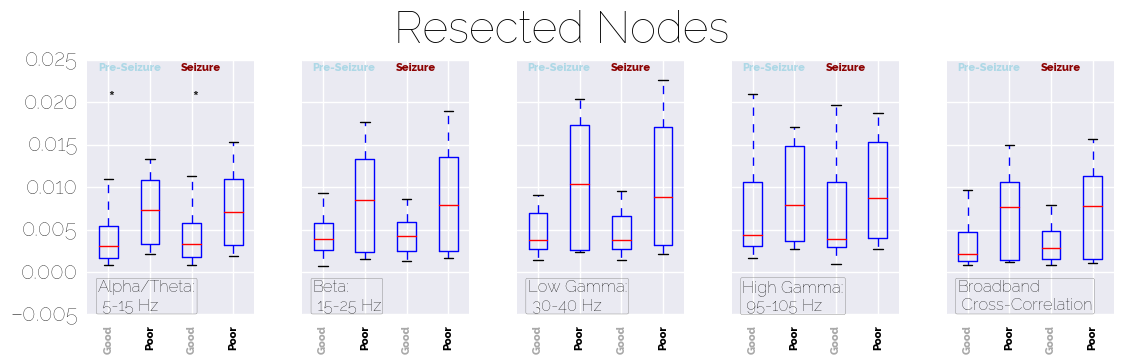

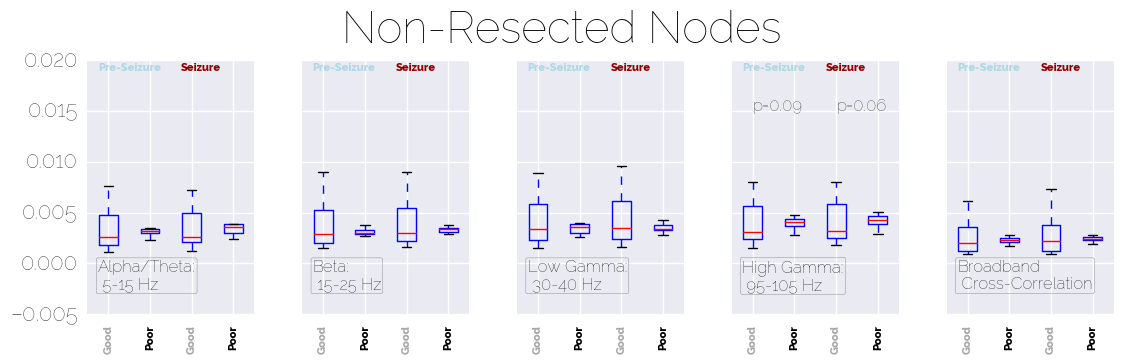

In [27]:
# Figure font options
font1 = {'family':'raleway',
        'color': 'lightblue',
        'weight':'bold',
        'size':8,
        }
font2 = {'family':'raleway',
        'color': 'darkred',
        'weight':'bold',
        'size':8,
        }
fig,axs = plt.subplots(1,5,sharey=True)
fig.set_size_inches((12,4))
fig.suptitle('Resected Nodes',fontdict={'family':'raleway','size':18,'color':'black'})
for ax, fconn in zip(axs,['alphatheta','beta','lowgamma','highgamma','broadband_CC']):
    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta:\n 5-15 Hz'
    if(fconn == 'beta'):
        title = 'Beta:\n 15-25 Hz'
    if(fconn == 'lowgamma'):
        title = 'Low Gamma:\n 30-40 Hz'
    if(fconn == 'highgamma'):
        title = 'High Gamma:\n 95-105 Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband\n Cross-Correlation'

    max_y = 0.025
    min_y = -0.005
    ax.boxplot([good_pre_res[fconn],poor_pre_res[fconn],good_res[fconn],poor_res[fconn]])
    s,pre_p = scipy.stats.ranksums(good_pre_res[fconn], poor_pre_res[fconn])
    print title, 'pre', s,pre_p
    s,post_p = scipy.stats.ranksums(good_res[fconn], poor_res[fconn])
    print title, 'post',s,post_p
    ax.text(0.75,max_y-(max_y-min_y)*0.04,'Pre-Seizure',fontdict=font1)
    ax.text(2.75,max_y-(max_y-min_y)*0.04,'Seizure',fontdict=font2)
    ax.text(0.75, min_y+(max_y-min_y)*0.02,title, \
            fontdict={'family':'raleway','size':12,'color':'black'}, \
            bbox=dict(facecolor='none',edgecolor='gray',boxstyle='round,pad=0.1'))
    ax.set_ylim([min_y,max_y])
    ax.set_xticks([1,2,3,4])
    ax.set_xticklabels(['Good','Poor','Good','Poor'],fontdict={'size':8,'weight':'bold'},rotation='vertical')
    for ii in range(1,4,2):
        ax.get_xticklabels()[ii].set_color('black')
    for ii in range(0,4,2):
        ax.get_xticklabels()[ii].set_color('darkgray')
    
    if pre_p < 0.001:
        ax.text(1.0,0.02,'***',{'weight':'bold', 'size':12})
    elif pre_p < 0.01:
        ax.text(1.0,0.02,'**',{'weight':'bold', 'size':12})
    elif pre_p < 0.05:
        ax.text(1.0,0.02,'*',{'weight':'bold', 'size':12})
    elif pre_p < 0.1:
        ax.text(1.0,0.02,'p=%0.2f'%pre_p,{'weight':'normal', 'size':12})
    
    if post_p < 0.001:
        ax.text(3.0,0.02,'***',{'weight':'bold', 'size':12})
    elif post_p < 0.01:
        ax.text(3.0,0.02,'**',{'weight':'bold', 'size':12})
    elif post_p < 0.05:
        ax.text(3.0,0.02,'*',{'weight':'bold', 'size':12})
    elif post_p < 0.1:
        ax.text(3.0,0.02,'p=%0.2f'%post_p,{'weight':'normal', 'size':12})
        
plt.tight_layout()
# plt.show()
fig.savefig('%s/../fig/Figure5A.svg'%(comp_dir))


fig,axs = plt.subplots(1,5,sharey=True)
fig.set_size_inches((12,4))
fig.suptitle('Non-Resected Nodes',fontdict={'family':'raleway','size':18,'color':'black'})
for ax, fconn in zip(axs,['alphatheta','beta','lowgamma','highgamma','broadband_CC']):
    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta:\n 5-15 Hz'
    if(fconn == 'beta'):
        title = 'Beta:\n 15-25 Hz'
    if(fconn == 'lowgamma'):
        title = 'Low Gamma:\n 30-40 Hz'
    if(fconn == 'highgamma'):
        title = 'High Gamma:\n 95-105 Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband\n Cross-Correlation'

    max_y = 0.020
    min_y = -0.005
    ax.boxplot([good_pre_non_res[fconn],poor_pre_non_res[fconn],good_non_res[fconn],poor_non_res[fconn]])
    s,pre_p = scipy.stats.ranksums(good_pre_non_res[fconn], poor_pre_non_res[fconn])
    print title, 'pre', s,pre_p
    s,post_p = scipy.stats.ranksums(good_non_res[fconn], poor_non_res[fconn])
    print title, 'post',s,post_p
    ax.text(0.75,max_y-(max_y-min_y)*0.04,'Pre-Seizure',fontdict=font1)
    ax.text(2.75,max_y-(max_y-min_y)*0.04,'Seizure',fontdict=font2)
    ax.text(0.75, min_y+(max_y-min_y)*0.1,title,\
            fontdict={'family':'raleway','size':12,'color':'black'},\
           bbox=dict(facecolor='none',edgecolor='gray',boxstyle='round,pad=0.1'))
    ax.set_ylim([min_y,max_y])
    ax.set_xticks([1,2,3,4])
    ax.set_xticklabels(['Good','Poor','Good','Poor'],fontdict={'size':8,'weight':'bold'},rotation='vertical')
    for ii in range(1,4,2):
        ax.get_xticklabels()[ii].set_color('black')
    for ii in range(0,4,2):
        ax.get_xticklabels()[ii].set_color('darkgray')
    if pre_p < 0.001:
        ax.text(1.0,0.015,'***',{'weight':'bold', 'size':12})
    elif pre_p < 0.01:
        ax.text(1.0,0.015,'**',{'weight':'bold', 'size':12})
    elif pre_p < 0.05:
        ax.text(1.0,0.015,'*',{'weight':'bold', 'size':12})
    elif pre_p < 0.1:
        ax.text(1.0,0.015,'p=%0.2f'%pre_p,{'weight':'normal', 'size':12})
    
    if post_p < 0.001:
        ax.text(3.0,0.015,'***',{'weight':'bold', 'size':12})
    elif post_p < 0.01:
        ax.text(3.0,0.015,'**',{'weight':'bold', 'size':12})
    elif post_p < 0.05:
        ax.text(3.0,0.015,'*',{'weight':'bold', 'size':12})
    elif post_p < 0.1:
        ax.text(3.0,0.015,'p=%0.2f'%post_p,{'weight':'normal', 'size':12})

plt.tight_layout()
# plt.show()
fig.savefig('%s/../fig/Figure5B.svg'%(comp_dir))

<h1>Figure 7B. Change in synchronizability as a feature </h1>

alphatheta 0.152564288315 0.878741889038
beta -1.16965954375 0.242138004949
lowgamma -3.30555958015 0.000947869493451
lowgamma -3.30555958015 0.000947869493451
highgamma -1.11880478097 0.263223431617
broadband_CC -0.355983339401 0.721853042222


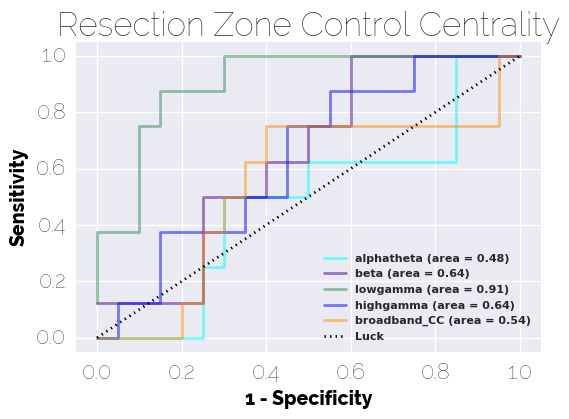

In [30]:
fig,axs = plt.subplots(1,1)
ax = axs
fig.set_size_inches((6,4))

width = -1
all_features = []
roc_results = []
for fconn in ['alphatheta','beta','lowgamma','highgamma','broadband_CC']:

    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta: 5-15 Hz'
    if(fconn == 'beta'):
        title = 'Beta: 15-25 Hz'
    if(fconn == 'lowgamma'):
        title = 'Low Gamma: 30-40 Hz'
    if(fconn == 'highgamma'):
        title = 'High Gamma: 95-105 Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband Cross-Correlation'

    skip_chop = True
    skip_mayo = False
    skip_hup = False
    dilate_radius = 0
    all_cres = gather_cres_results(dilate_radius,fconn)
    all_cres = get_norm(all_cres, width=width)
    width = len(map(lambda x: x.values(), all_cres.values())[0][0])
    num_fts = width

    clip_iter = 0
    patient_idx = all_cres.keys()
    ft_matrix = []

    out_txt = 'pt_id,' #First column
    index_col = []    

    for patient_id in sorted(patient_idx):
            if(skip_chop and 'CHOP' in patient_id):
                continue
            if(skip_mayo and 'Study' in patient_id):
                continue
            if(skip_hup and 'HUP' in patient_id):
                continue
            if not all_cres[patient_id]:
                continue
    #                 print patient_id
            index_col.append(patient_id)
            
            for pid,clips in sorted(all_cres.items(), key=lambda x:x[0]):                    
                if(pid != patient_id):
                    continue
                outcome = data['PATIENTS'][patient_id]['Outcome']              
                # Create entry for each subtype
                for subtype in ['A', 'B', 'C', 'D']:
                    avg_data = np.array(())
                    for clip, clip_data in sorted(clips.items(), key=lambda x:x[0]):
                        stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip]['SeizurePhenotype']
                        if stype != subtype:
                            continue
                        res = clip_data                        
                        if(res.shape[0] == num_fts+1):
                            res = res[:num_fts]
                        try:                
                            avg_data = np.hstack((avg_data,np.reshape(res,(num_fts,1))))
                        except Exception:                
                            avg_data = np.reshape(res,(num_fts,1))                    
                    # Check if subtype exists
                    if avg_data.shape[0] == 0:
                        continue
                    
                    #%DEBUG
#                     print patient_id, clip, avg_data.shape
                    avg_data = np.nanmedian(avg_data,axis=1)
    
                    # Update row_data
                    row_data = np.append([clip_iter+1],avg_data)
                    row_data = np.reshape(row_data, (row_data.shape[0],1))
                    # Update header
                    if(clip_iter == 0):
                        for t in range(1,num_fts+1):
                            out_txt += 'base_sync_'+str(t)+'_%s,'%fconn
                    if(get_outcome(outcome) == 'Good'):        
                        row_data = np.append(row_data,[0])        
                    else:
                        row_data = np.append(row_data,[1])
                    row_data = np.reshape(row_data, (row_data.shape[0],1))
                    try:
                        all_data = np.hstack((all_data, np.reshape(row_data,(num_fts+2,1))))
                    except Exception:
                        all_data = row_data
                    clip_iter += 1
    ft_matrix = np.array(all_data).T
    all_data = ft_matrix[:,1:width+1]
    outcomex = ft_matrix[:,width+1]
    
    good_outcome_feature = np.nanmean(all_data[outcomex==0,width/2:],axis=1)-np.nanmean(all_data[outcomex==0,:width/2],axis=1)
    poor_outcome_feature = np.nanmean(all_data[outcomex==1,width/2:],axis=1)-np.nanmean(all_data[outcomex==1,:width/2],axis=1)
    all_features.append(good_outcome_feature)
    all_features.append(poor_outcome_feature)
    s,p = scipy.stats.ranksums(good_outcome_feature, poor_outcome_feature)
    print fconn, s,p
    if p < 0.05:
        print fconn, s,p
    
    fpr,tpr,threshold = roc_curve(outcomex,np.nanmean(all_data[:,width/2:],axis=1)-np.nanmean(all_data[:,:width/2],axis=1))    
    roc_auc = auc(fpr,tpr)
    roc_results.append((fconn,roc_auc,fpr,tpr))
    
# ax.boxplot(all_features)

# ax.set_xticks([1,2,3,4,5,6,7,8,9,10])
# ax.set_xticklabels(['Good','Poor','Good','Poor','Good','Poor','Good','Poor','Good','Poor'],fontdict={'size':8,'weight':'bold'},rotation='vertical')
# ax.set_ylim([-0.35,0.15])
# for ii in range(1,10,2):
#     ax.get_xticklabels()[ii].set_color('black')
# for ii in range(0,10,2):
#     ax.get_xticklabels()[ii].set_color('darkgray')
# ax.text(0.75,-0.3,'Alpha/Theta:\n 5-15 Hz',fontdict={'size':10,'weight':'normal'})
# ax.text(2.75,-0.3,'Beta:\n 15-25 Hz',fontdict={'size':10,'weight':'normal'})
# ax.text(4.75,-0.3,'Low Gamma:\n 30-40 Hz',fontdict={'size':10,'weight':'normal'})
# ax.text(5.25,0.1,'*',fontdict={'size':22,'weight':'bold'})
# ax.text(6.75,-0.3,'High Gamma:\n 95-105 Hz',fontdict={'size':10,'weight':'normal'})
# ax.text(8.75,-0.3,'Broadband\n Cross-\nCorrelation',fontdict={'size':10,'weight':'normal'})
# ax.set_ylabel('Change in Resection\n Control Centrality \n(pre-ictal to ictal)',fontdict={'size':14,'weight':'bold'})

# ax = axs[1]
colors = ['cyan', 'indigo', 'seagreen', 'blue', 'darkorange', 'yellow']
i = 0
for fconn, roc_auc, fpr, tpr in roc_results:
    ax.plot(fpr, tpr, lw=2, color=colors[i], linestyle='-', label = '%s (area = %0.2f)'%(fconn,roc_auc), alpha=0.5)
    ax.hold(True)
    i += 1
# Plot the ROC curve for luck along with area
ax.plot([0, 1], [0, 1], linestyle=':', lw=2, color='k', label='Luck')
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])

ax.set_xlabel('1 - Specificity',fontdict={'size':14,'weight':'bold'})
ax.set_ylabel('Sensitivity',fontdict={'size':14,'weight':'bold'})
ax.legend(loc="lower right",prop={'size':8,'weight':'bold', 'family':'normal'})

plt.title('Resection Zone Control Centrality')
plt.savefig('../../fig/Figure7B.svg',bbox_inches='tight', format='svg', dpi=1200)

<h1> e01B. Cross-Validation using basic connectivity features </h1>

In [ ]:
plt.hold(True)
rsrs = np.random.randint(100,size=1)
for rs in range(rsrs,rsrs+3):
    # Parameters
    k1 = 5 # Number of features remaining after first round of feature reduction
    # k2 = 350 # Number of features remaining after second round of feature reduction

    # Load DataFrame
    # Load DataFrame
#     df1 = pd.read_csv('~/gdrive/aim3/code/data/e01B_broadband_CC.csv')
#     df2 = pd.read_csv('~/gdrive/aim3/code/data/e01B_alphatheta.csv')
#     df3 = pd.read_csv('~/gdrive/aim3/code/data/e01B_beta.csv')
#     df4 = pd.read_csv('~/gdrive/aim3/code/data/e01B_lowgamma.csv')
    df5 = pd.read_csv('~/gdrive/aim3/code/data/e01B_highgamma.csv')
#     df = pd.concat([df1, df2, df3, df4, df5],axis=1)
    df = df5

    if(True):
        df = df.dropna()

    # Generate feature matrix and target vectors
    print 'Generating feature matrix ...'
    X = np.array(df[df.columns.difference(['Unnamed: 0','pt_id','Outcome'])])
    print X.shape
#     y = np.array(df.Outcome.iloc[:,0])
    y = np.array(df.Outcome)

    if(False):
        imp = Imputer(missing_values = 'NaN', strategy='mean', axis=0)
        X = imp.fit(X).transform(X)    

    # Build a Random Forest with 1000 estimators
    classifier_VR = RandomForestClassifier(n_estimators=1000, random_state=rs)

    # Perform the first prune using ANOVA F test using mutual information
    print 'Feature reduction to %i features ...'%(min(k1,X.shape[1]))
    prune1 = SelectKBest(mutual_info_classif, k=min(k1,X.shape[1]))
    X = prune1.fit_transform(X,y)

    # # Perform a second prune by selecting features optimally branched using the classifier
    # print 'Second round of feature reduction ...'
    # clf = classifier_VR.fit(X,y)
    # model = SelectFromModel(clf, prefit=True)
    # X = model.transform(X)

    # # Generate polynomial (degree 2) with interaction term feature set to account 
    # # for non-linear combinations.
    # # This will include cross-interaction terms to take into account non-linear combinations 
    # # of clinical variables.
    # print 'Generating polynomial combination of features ...'
    # poly = PolynomialFeatures(2)
    # X = poly.fit_transform(X)

    # # Perform the third prune using ANOVA F test using mutual information
    # print 'Final round of feature reduction to %i features ...'%k2
    # prune2 = SelectKBest(mutual_info_classif, k=k2)
    # X = prune2.fit_transform(X,y)

    # Compute 8-fold cross-validation True Positive Rate (TPR) and False Positive Rate (FPR)
    # to generate ROC curves.
    print 'Performing cross validation ...'
    n_splits = 5
    cv = StratifiedKFold(n_splits=n_splits, random_state=rs)
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)

    from itertools import cycle
    colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
    lw = 2
    i = 0

    # for (train, test) in cv.split(X,y):
    for (train, test), color in zip(cv.split(X, y), colors):
        # Ignore any folds that do not have any poor outcomes 
        # to maintain representation of entire dataset.
        if(sum(y[test]) == 0):
            print train,test
            continue
        probas_ = classifier_VR.fit(X[train], y[train]).predict_proba(X[test])
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=lw, color=color, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',label='Luck')

    # Compute mean Area Under Curve (AUC)    
    print 'Computing AUC of ROC ...'
    mean_tpr /= n_splits
    mean_tpr[-1] = 1.0
    mean_auc_VR = auc(mean_fpr, mean_tpr)
    sigma_auc_VR = 2*np.sqrt(mean_auc_VR*(1-mean_auc_VR)/4)

    plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
             label='Mean ROC (area = %0.2f)' % mean_auc_VR, lw=lw)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    # Compute Mean AUC and Confidence interval using \sigma_max
    print "Mean AUC: %0.3f $\pm$ %0.3f"%(mean_auc_VR,sigma_auc_VR)

<h1> e01B. Prediction on Hold Out Test Set </h1>

<h2> Create developmental and validation cohorts </h2>

In [ ]:
# Load DataFrame
df1 = pd.read_csv('~/gdrive/aim3/code/data/e01B_broadband_CC.csv')
df2 = pd.read_csv('~/gdrive/aim3/code/data/e01B_alphatheta.csv')
cols_to_use = df2.columns.difference(df1.columns)
df = pd.merge(df1, df2[cols_to_use], left_index=True, right_index=True, how='outer')

df3 = pd.read_csv('~/gdrive/aim3/code/data/e01B_beta.csv')
cols_to_use = df3.columns.difference(df.columns)
df = pd.merge(df, df3[cols_to_use], left_index=True, right_index=True, how='outer')

df4 = pd.read_csv('~/gdrive/aim3/code/data/e01B_lowgamma.csv')
cols_to_use = df4.columns.difference(df.columns)
df = pd.merge(df, df4[cols_to_use], left_index=True, right_index=True, how='outer')

df5 = pd.read_csv('~/gdrive/aim3/code/data/e01B_highgamma.csv')
cols_to_use = df5.columns.difference(df.columns)
df = pd.merge(df, df5[cols_to_use], left_index=True, right_index=True, how='outer')

df = df.dropna()

# Determine randomly generated train and test split 
rs = ShuffleSplit(n_splits=1, test_size= 0.33)
for train_index, test_index in rs.split(df['Unnamed: 0']):
    train = train_index
    test = test_index

train_ptx = ['Study017','HUP083','CHOP42','CHOP45','CHOP20','CHOP08','CHOP43','CHOP40','Study016','Study020','CHOP46','HUP078','HUP073','HUP075','Study012','HUP070','Study022']
test_ptx = ['CHOP47','CHOP27','HUP080','Study029','Study028','HUP086','HUP074','HUP082','Study019']
train = []
test = []
for ii, pt in enumerate(df['Unnamed: 0']):
    if(pt in train_ptx):
        train.append(ii)
    elif(pt in test_ptx):
        test.append(ii)

#train = [19, 23, 16, 17, 13, 11, 21, 20, 18, 1, 9, 4, 7, 6, 15, 8,  0]
#test = [10, 12, 25,  2,  3, 22,  5, 24, 14]
train_idx = df.iloc[train,:]['Unnamed: 0']
test_idx = df.iloc[test,:]['Unnamed: 0']
print train_idx, test_idx, df.iloc[test,:].Outcome


<h2> Create the feature matrix $X$ and target outcome $y$ for all 4 models </h2>

In [ ]:
df4 = df

# Generate feature matrix and target vectors
print 'Generating feature matrix ...'
df4_train_idx = np.where(df4['Unnamed: 0'].isin(train_idx))
df4_test_idx = np.where(df4['Unnamed: 0'].isin(test_idx))
X4 = np.array(df4[df4.columns.difference(['Unnamed: 0','pt_id','Outcome'])])
y4 = np.array(df4.Outcome)
X4_labels = df4.columns.difference(['Unnamed: 0','pt_id','Outcome'])

<h3> Perform feature reduction for each model</h3>

In [ ]:
# Parameters
k1 = 4500 # Number of features remaining after first round of feature reduction
# k2 = 350 # Number of features remaining after second round of feature reduction

# Build a Random Forest with 5000 estimators
classifier4 = RandomForestClassifier(n_estimators=1000)

## Do feature reduction on Model 4
print 'Model 4 ..................'
X = np.copy(X4)
y = np.copy(y4)

# Perform the first prune using ANOVA F test using mutual information
print 'Feature reduction to %i features ...'%(min(k1,X.shape[1]))
prune1 = SelectKBest(mutual_info_classif, k=min(k1,X.shape[1]))
X = prune1.fit_transform(X,y)
X4_labels = X4_labels[prune1.get_support()]
X4_pruned = X

# # Perform a second prune by selecting features optimally branched using the classifier
# print 'Second round of feature reduction ...'
# clf = classifier4.fit(X,y)
# model = SelectFromModel(clf, prefit=True)
# X = model.transform(X)
# X4_labels = X4_labels[model.get_support()]

# # Generate polynomial (degree 2) with interaction term feature set to account 
# # for non-linear combinations.
# # This will include cross-interaction terms to take into account non-linear combinations 
# # of clinical variables.
# print 'Generating polynomial combination of features ...'
# poly = PolynomialFeatures(2)
# X = poly.fit_transform(X)
# X4_labels = np.array(poly.get_feature_names(X4_labels))

# # Perform the third prune using ANOVA F test using mutual information
# print 'Final round of feature reduction to %i features ...'%k2
# prune2 = SelectKBest(mutual_info_classif, k=k2)
# X = prune2.fit_transform(X,y)
# X4_pruned = X
# X4_labels = X4_labels[prune2.get_support()]

<h3> Measure ROC and plot </h3>

In [ ]:
colors = ['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange']
lw = 2

# Train and test Model 4
X4_train = np.squeeze(X4_pruned[df4_train_idx,:])
y4_train = y4[df4_train_idx]
X4_test = np.squeeze(X4_pruned[df4_test_idx,:])
y4_test = y4[df4_test_idx]
y4_hat = classifier4.fit(X4_train,y4_train).predict_proba(X4_test)
fpr, tpr, thresholds = roc_curve(y4_test,y4_hat[:,1])
roc_auc = auc(fpr, tpr)
i = 4
plt.plot(fpr, tpr, lw=lw, color=colors[i], linestyle='--', label = 'Model %d (area = %0.2f)'%(i,roc_auc), alpha=0.5)
# Save Model 4 for model persistence
# joblib.dump(classifier4, 'classifier4.pkl')

# Plot the ROC curve for luck along with area
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k', label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.title('Receiver operating characteristic')
plt.xlabel('False Postive Rate')
plt.ylabel('Trupe Postive Rate')
plt.legend(loc="lower right")
plt.show()

In [ ]:
train_idx, test_idx, df4['Unnamed: 0'].iloc[df4_test_idx], y4_hat, y4_test

<h1> Feature Learning </h1>

In [ ]:
# Compute feature importances
clf4 = classifier4

def _helper(job):
    '''
    This helper function runs one instance of model fitting and returns the top feature importances and their name.
    '''    
    classifier,X_labels,all_labels,importances,K = job
    print K
    # Sort feature importances
    importances = classifier.feature_importances_
    std = np.std([tree.feature_importances_ for tree in classifier4.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]

    # Print all feature importances
    fnames = []
    for f in range(K):
        fname = X4_labels[indices[f]]
        fnames.append((fname,importances[indices[f]]))
        return fnames

    
# Parallel version
n_iter = 100
K = 4500
    
def run_jobs(clf, X_train, y_train, X_labels, all_labels, K):
    '''
    This function runs n_iter instances of model fitting and keeps track of the top $K$ features. 
    This function uses multiple cores to speed up computation.
    '''
    jobs = []
    
    for n in range(n_iter):
        print n
        clf.fit(X_train, y_train)
        importances = clf.feature_importances_
        classifier = clf    
        jobs.append((classifier,X_labels,all_labels,importances,K))
    return jobs
    return_list = []
    n_proc = 40
    pool = Pool(n_proc)
    return_list = map(_helper, jobs)
    pool.close()
    return return_list

clf = clf4
X_train = X4_train
y_train = y4_train
X_labels = X4_labels
all_labels = df4.columns.difference(['Unnamed: 0','id','outcome_binary'])
return_list4 = run_jobs(clf, X_train, y_train, X_labels, all_labels, K)

In [ ]:
jobs = return_list4
all_importances = []
for job in jobs:
    all_importances.append(job[3])
all_importances = np.array(all_importances)
print all_importances.shape
importances = np.mean(all_importances,axis=0)
indices = np.argsort(importances)[::-1]

# Print all feature importances
fnames = []
for f in range(K):
    fname = X4_labels[indices[f]]
    fnames.append((fname,importances[indices[f]]))
lines = []
for fname, val in fnames:
    lines.append('%s,%s'%(fname,val))

In [ ]:
import sys
import glob
import json
import time

for fconn in ['broadband_CC','alphatheta','beta','lowgamma','highgamma']:
    skip_chop = False
    skip_mayo = False
    skip_hup = False
    window = 1
    
    # Load DataFrame
    df = pd.read_csv('~/gdrive/aim3/code/data/e01B_%s.csv'%fconn)
    
    good = np.array(df[df.Outcome==0][sorted(df.columns.difference(['Unnamed: 0','Outcome','pt_id']),key=lambda x: int(x.split('_')[2]))]).T
    poor = np.array(df[df.Outcome==1][sorted(df.columns.difference(['Unnamed: 0','Outcome','pt_id']),key=lambda x: int(x.split('_')[2]))]).T

    times = np.arange(-300.0,600,window)*1.0/60

    res_sync = []
    for k in good:
        res_sync.append(np.nanmean(k[~np.isnan(k)]))
#     res_sync = res_sync[:-1]    
    
    error = scipy.stats.sem(good.T,nan_policy='omit')    
#     error = error[:-1]
#     print len(res_sync), times.shape, error.shape
    plt.plot(times,res_sync,'b-')
    plt.fill_between(times,res_sync-error,res_sync+error,facecolor='blue',alpha=0.25)
    plt.hold(True)

    res_sync = []
    for k in poor:
        res_sync.append(np.nanmean(k[~np.isnan(k)]))
#     res_sync = res_sync[:-1]
    error = scipy.stats.sem(poor.T,nan_policy='omit')
#     error = error[:-1]
    plt.plot(times,res_sync,'r-')
    plt.fill_between(times,res_sync-error,res_sync+error,facecolor='red',alpha=0.25)
    
    ##### PROCESS CSV RF FEATS
#     lines = open(os.path.expanduser('~/gdrive/tmp/aim3/rf_feats.csv'),'r').readlines()
    max_val = np.max(map(lambda x: float(x.split(',')[1]),lines))
    for line in lines:
        ft = line.split(',')[0]
        val = float(line.split(',')[1])
#         print ft,val
        ft_time = int(ft.split('_')[2])
        ft_fconn = ft.split('_')[3]
        if(ft_fconn == fconn or ft_fconn in fconn):
#             print fconn, ft_fconn, ft_time,val
            plt.fill_between([(ft_time-5-300)/60.0, (ft_time+5-300)/60.0], np.min(res_sync-error)-np.abs(np.min(res_sync-error))*0.2, np.max(res_sync+error)+np.abs(np.max(res_sync+error))*0.5, facecolor=(val,1-val,1-val),edgecolor=(val,1-val,1-val),alpha=min(val/max_val,1))
            pass
        

    # plt.xticks(map(lambda x: x+1, range(times.shape[0]))[::2],times[::2])
    # plt.yticks([])
    plt.xlabel('Time (min.)')
    plt.ylabel('$sync_{res}(t)$')
    plt.xlim([-5.0,10.0])
    plt.ylim([np.min(res_sync-error)-np.abs(np.min(res_sync-error))*0.2, np.max(res_sync+error)+np.abs(np.max(res_sync+error))*0.5])
    plt.title('$sync_{res}(t)$ in %s connectivity of all clips'%(fconn))
    plt.legend(['Good Outcome','Poor Outcome'])
#     plt.show()
    fig = plt.gcf()
    fig.set_size_inches(18.5,2.11)
    fig.savefig(os.path.expanduser('~/gdrive/aim3/fig/e01B.ROZ_delta_clip_%s_with_fts.png'%(fconn)),dpi=100,bbox_inches='tight')
    plt.hold(False)